In [1]:
#To install the necessary packages, please run this cell:
!pip install -r pip_requirements.txt


In [2]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import seaborn as sns

# Add 'src' to the system path
sys.path.append(str(Path().resolve() / 'src'))
from src.data.process_data import create_tmdb_dataset
from src.utils.load_data import load_raw_data
from src.utils.data_utils import *
from src.utils.plot_utils import *
from src.models.lda_model import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charlottemeyer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# First, run the clean_data script to clean the TMDB dataset
%run src/scripts/clean_data.py

Loading data from data/raw/TMDB_movie_dataset_v11.csv...
original df shape (1142342, 24)
after status (1115961, 24)
after adult (1009755, 24)
after release date (673025, 24)
after release year (673025, 25)
after runtime (458914, 25)
after duplicates (455150, 25)
after numeric columns (455150, 25)
after string columns (455150, 25)
after production companies (455150, 25)
after select columns (455150, 13)
Loading data from data/raw/movie.metadata.tsv...
original df shape (81740, 9)
after release year (44006, 9)
after runtime (34490, 9)
after duplicates (34435, 9)
after numeric columns (34435, 9)
after string columns (34435, 9)
after select columns (34435, 5)
Loading data from data/raw/plot_summaries.txt...


In [4]:
# from clean data files, creates a dataframe with TMDB movies 
df = create_tmdb_dataset('data/processed/TMDB_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363442 entries, 0 to 455149
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   title                 363441 non-null  object
 1   release_date          363442 non-null  object
 2   revenue               363442 non-null  int64 
 3   runtime               363442 non-null  int64 
 4   budget                363442 non-null  int64 
 5   original_language     363442 non-null  object
 6   overview              363442 non-null  object
 7   genres                363442 non-null  object
 8   production_companies  363442 non-null  object
 9   production_countries  363442 non-null  object
 10  spoken_languages      363442 non-null  object
 11  keywords              363442 non-null  object
 12  release_year          363442 non-null  int64 
 13  dvd_era               363442 non-null  object
dtypes: int64(4), object(10)
memory usage: 41.6+ MB


# DVD releases over time

In [5]:
df_dvd_releases = load_raw_data('data/processed/dvd_releases.csv')
df_dvd_releases['dvd_release_date'] = pd.to_datetime(df_dvd_releases['dvd_release_date'])
df_grouped = df_dvd_releases.resample('ME', on='dvd_release_date').size()


Loading data from data/processed/dvd_releases.csv...


In [6]:
# Calculate our eras using our data
peak_date = df_grouped.idxmax()
peak_value = df_grouped.max()
mean_releases = df_grouped.mean()
std_releases = df_grouped.std()
threshold_low = mean_releases - std_releases
threshold_high = mean_releases + std_releases

pre_dvd_end = df_grouped[df_grouped > threshold_high].index[0]  # First time crosses upper threshold
post_dvd_start = df_grouped[df_grouped > threshold_high].index[-1]  # Last time crosses upper threshold
print(f"Pre-DVD Era: Before {pre_dvd_end.strftime('%Y')}")
print(f"DVD Era: {pre_dvd_end.strftime('%Y')} to {post_dvd_start.strftime('%Y')}")
print(f"Post-DVD Era: After {post_dvd_start.strftime('%Y')}")

Pre-DVD Era: Before 1997
DVD Era: 1997 to 2013
Post-DVD Era: After 2013


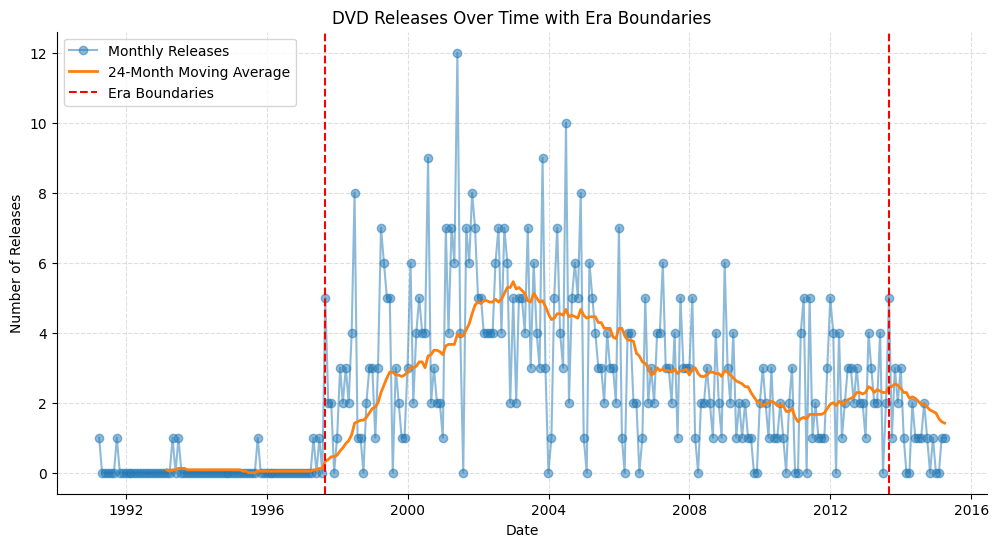

In [7]:
moving_avg = df_grouped.rolling(window=24).mean() 
plt.figure(figsize=(12, 6))

plt.plot(df_grouped.index, df_grouped.values, marker='o', alpha=0.5, label='Monthly Releases')
plt.plot(moving_avg.index, moving_avg.values, linewidth=2, label='24-Month Moving Average')

# Draw the era boundaries
plt.axvline(x=pre_dvd_end, color='r', linestyle='--', label='Era Boundaries')
plt.axvline(x=post_dvd_start, color='r', linestyle='--')

style_plot('DVD Releases Over Time with Era Boundaries', 'Date', 'Number of Releases', True)

# General Overview

# Revenue overview
We first obtain an overview of movie revenues, considering all movies together.

We then analyse revenue by DVD eras.

In [8]:
# Summary statistics for each DVD era
print('Summary statistics of revenue for each DVD era:')
df[df.revenue > 0].groupby('dvd_era')['revenue'].describe().reindex(['pre', 'during', 'post']).transpose()

Summary statistics of revenue for each DVD era:


dvd_era           pre        during          post
count    3.079000e+03  6.114000e+03  5.864000e+03
mean     3.269406e+07  5.134336e+07  4.916675e+07
std      7.215145e+07  1.280726e+08  1.584989e+08
min      1.000000e+00  1.000000e+00  1.000000e+00
25%      1.220048e+06  5.169648e+05  1.000000e+05
50%      8.894289e+06  6.635626e+06  2.239196e+06
75%      2.917746e+07  4.198485e+07  2.027746e+07
max      9.201000e+08  2.923706e+09  2.800000e+09

The average revenue is the for the pre-DVD era is 32.69M
The average revenue is the for the during-DVD era is 51.34M
The average revenue is the for the post-DVD era is 49.17M


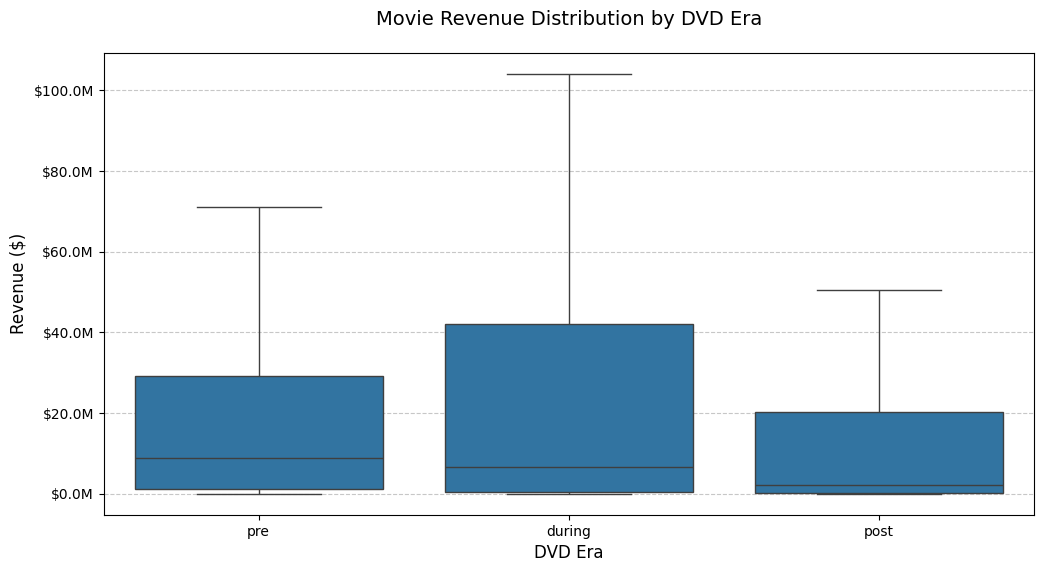

In [9]:
# Create boxplot with seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='dvd_era', 
    y='revenue',
    data=df[df['revenue'] > 0],  # Filter out zero revenues
    order=['pre', 'during', 'post'],  # Specify order of eras
    showfliers=False  # Hide outliers for better visualization
)

plt.title('Movie Revenue Distribution by DVD Era', pad=20, fontsize=14)
plt.xlabel('DVD Era', fontsize=12)
plt.ylabel('Revenue ($)', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e9:.1f}B' if x >= 1e9 else f'${x/1e6:.1f}M'))
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

print(f"The average revenue is the for the pre-DVD era is {df[(df['revenue'] > 0) & (df['dvd_era'] == 'pre')]['revenue'].mean()/1e6:.2f}M")
print(f"The average revenue is the for the during-DVD era is {df[(df['revenue'] > 0) & (df['dvd_era'] == 'during')]['revenue'].mean()/1e6:.2f}M")
print(f"The average revenue is the for the post-DVD era is {df[(df['revenue'] > 0) & (df['dvd_era'] == 'post')]['revenue'].mean()/1e6:.2f}M")


Using box plots we can see that revenue during the DVD era is higher than after. Let's also investigate the outliers.

In [10]:
def calculate_outlier_bounds(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    print(f"Q1: ${Q1/1e6:.2f}M")
    print(f"Q3: ${Q3/1e6:.2f}M")
    print(f"IQR: ${IQR/1e6:.2f}M")
    print(f"Upper bound: ${upper_bound/1e6:.2f}M")
    print(f"Number of outliers: {len(outliers)}")
    print(f"Percentage of outliers: {(len(outliers)/len(data))*100:.2f}%")
    
    return outliers

# Calculate outliers for each era
for era in ['pre', 'during', 'post']:
    print(f"\nOutlier Analysis for {era.upper()} DVD era:")
    era_data = df[(df['dvd_era'] == era) & (df['revenue'] > 0)]['revenue']
    outliers = calculate_outlier_bounds(era_data)
    
    # Show top 5 outliers
    print("\nTop 5 highest revenue outliers:")
    top_outliers = df[df['revenue'].isin(outliers)].nlargest(5, 'revenue')[['title', 'revenue', 'release_year']]
    print(top_outliers.to_string(index=False, 
                                float_format=lambda x: f"${x/1e6:.2f}M"))


Outlier Analysis for PRE DVD era:
Q1: $1.22M
Q3: $29.18M
IQR: $27.96M
Upper bound: $71.11M
Number of outliers: 341
Percentage of outliers: 11.08%

Top 5 highest revenue outliers:
                     title   revenue  release_year
             jurassic park 920100000          1993
          independence day 817400891          1996
e.t. the extra-terrestrial 792965500          1982
                 star wars 775398007          1977
             the lion king 763455561          1994

Outlier Analysis for DURING DVD era:
Q1: $0.52M
Q3: $41.98M
IQR: $41.47M
Upper bound: $104.19M
Number of outliers: 815
Percentage of outliers: 13.33%

Top 5 highest revenue outliers:
                                       title    revenue  release_year
                                      avatar 2923706026          2009
                                     titanic 2264162353          1997
                                the avengers 1518815515          2012
harry potter and the deathly hallows: part 2 13415

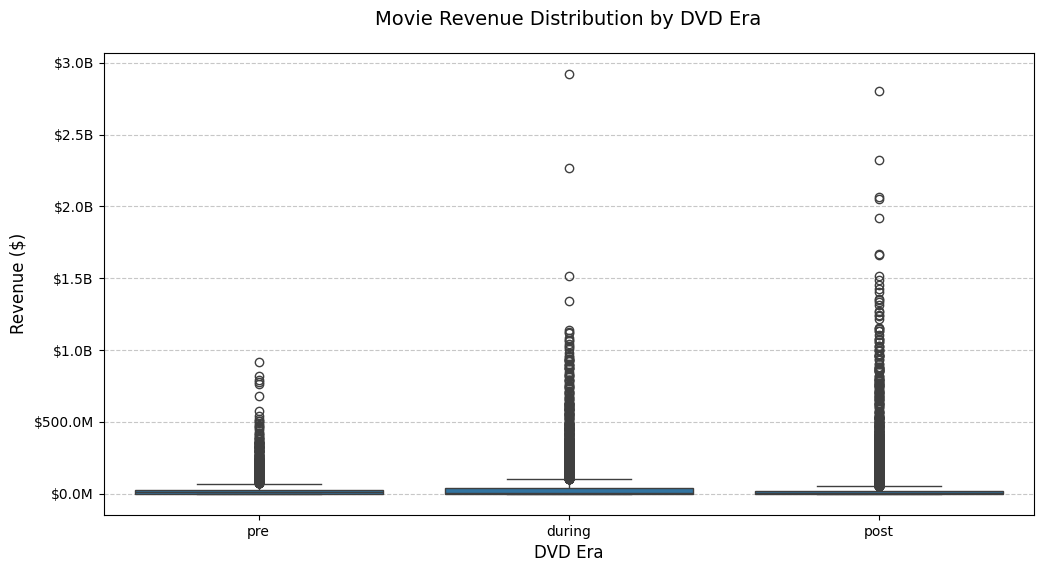

In [11]:
# Create boxplot with seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='dvd_era', 
    y='revenue',
    data=df[df['revenue'] > 0],  # Filter out zero revenues
    order=['pre', 'during', 'post'],  # Specify order of eras
    showfliers=True  # Hide outliers for better visualization
)

plt.title('Movie Revenue Distribution by DVD Era', pad=20, fontsize=14)
plt.xlabel('DVD Era', fontsize=12)
plt.ylabel('Revenue ($)', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e9:.1f}B' if x >= 1e9 else f'${x/1e6:.1f}M'))
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


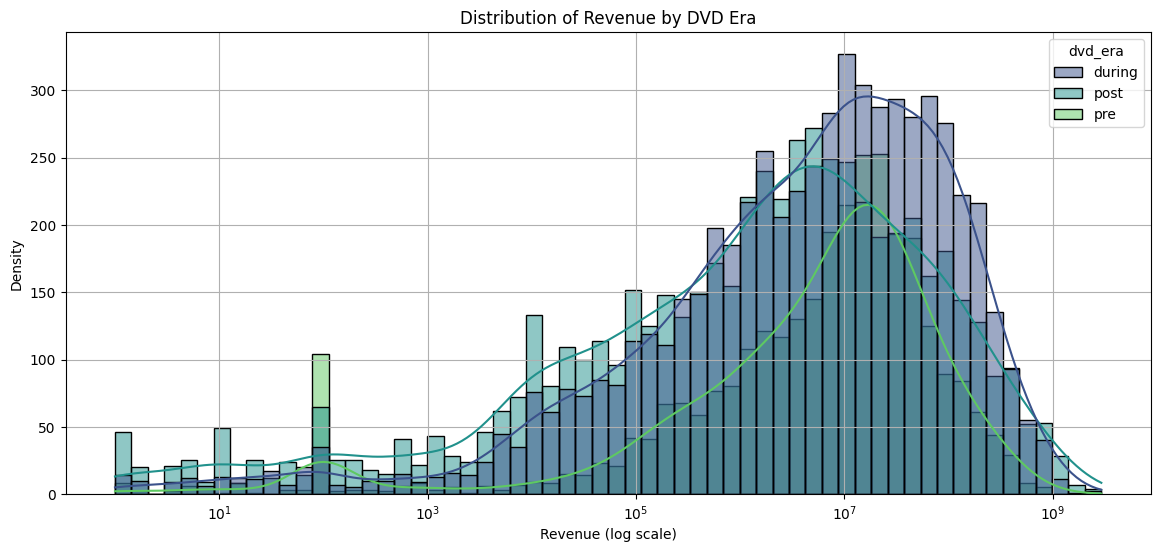

In [12]:
# Revenue per era
plot_revenue_per_era(df)

# Budget overview
We then consider budget distributions.

In [13]:
df_filtered = df[(df['budget'] > 0)]

print('Summary statistics of budget for each DVD era:')
df_filtered.groupby('dvd_era')['budget'].describe().reindex(['pre', 'during', 'post']).transpose()

Summary statistics of budget for each DVD era:


dvd_era           pre        during          post
count    3.047000e+03  9.461000e+03  1.162200e+04
mean     1.099735e+07  1.421298e+07  8.949124e+06
std      1.488503e+07  2.888789e+07  2.972991e+07
min      1.000000e+00  1.000000e+00  1.000000e+00
25%      6.000000e+05  2.000000e+05  3.000000e+03
50%      5.500000e+06  2.400000e+06  1.400000e+05
75%      1.500000e+07  1.400000e+07  3.500000e+06
max      1.750000e+08  3.790000e+08  8.880000e+08

We can see that most budget statistics (quantiles, median and mean) are lower in the post-DVD era, but the maximum budget is higher. 

We examine the budget trends in more details using plots. 

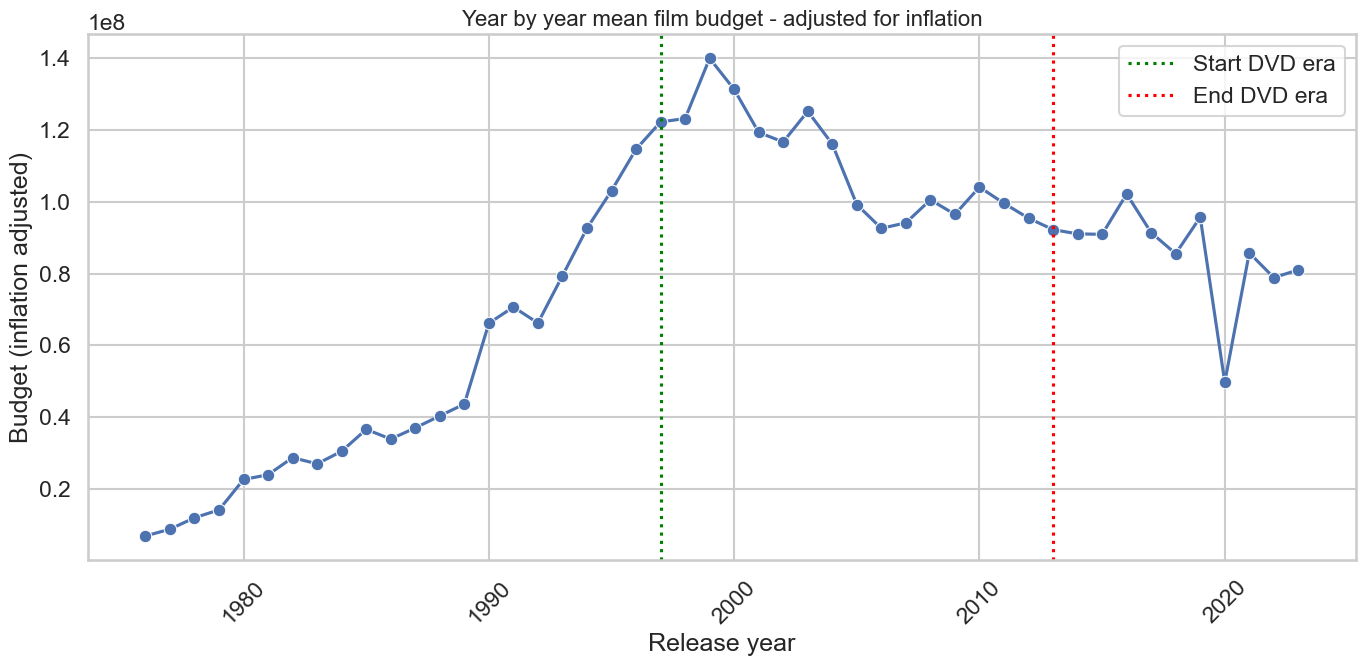

In [14]:
# Plot mean budget across time, accounting for inflation
plot_mean_budget_inflation(df)

We can use histograms to compare film budgets before, during and after the DVD era. We use a log-scale to represent movies with both small and high budgets on the same graph. This leads to the results of pre vs. post DVD era to be unreadable. 


We can nevertheless interpret the results for adjacent eras :
- Pre vs. during: before DVDs, only high budgets films were produced, with a mono-modal distribution, around 10^7 dollars budget. During the DVD era, the distribution widened, with smaller budget films being produced.
- During vs. post: after the DVD era, we see the distribution becoming more bimodal with another density maximum around 10^4 dollars.

Interpreting this is tricky : maybe more movies can become available in streaming services, pushing for smaller-budget productions.

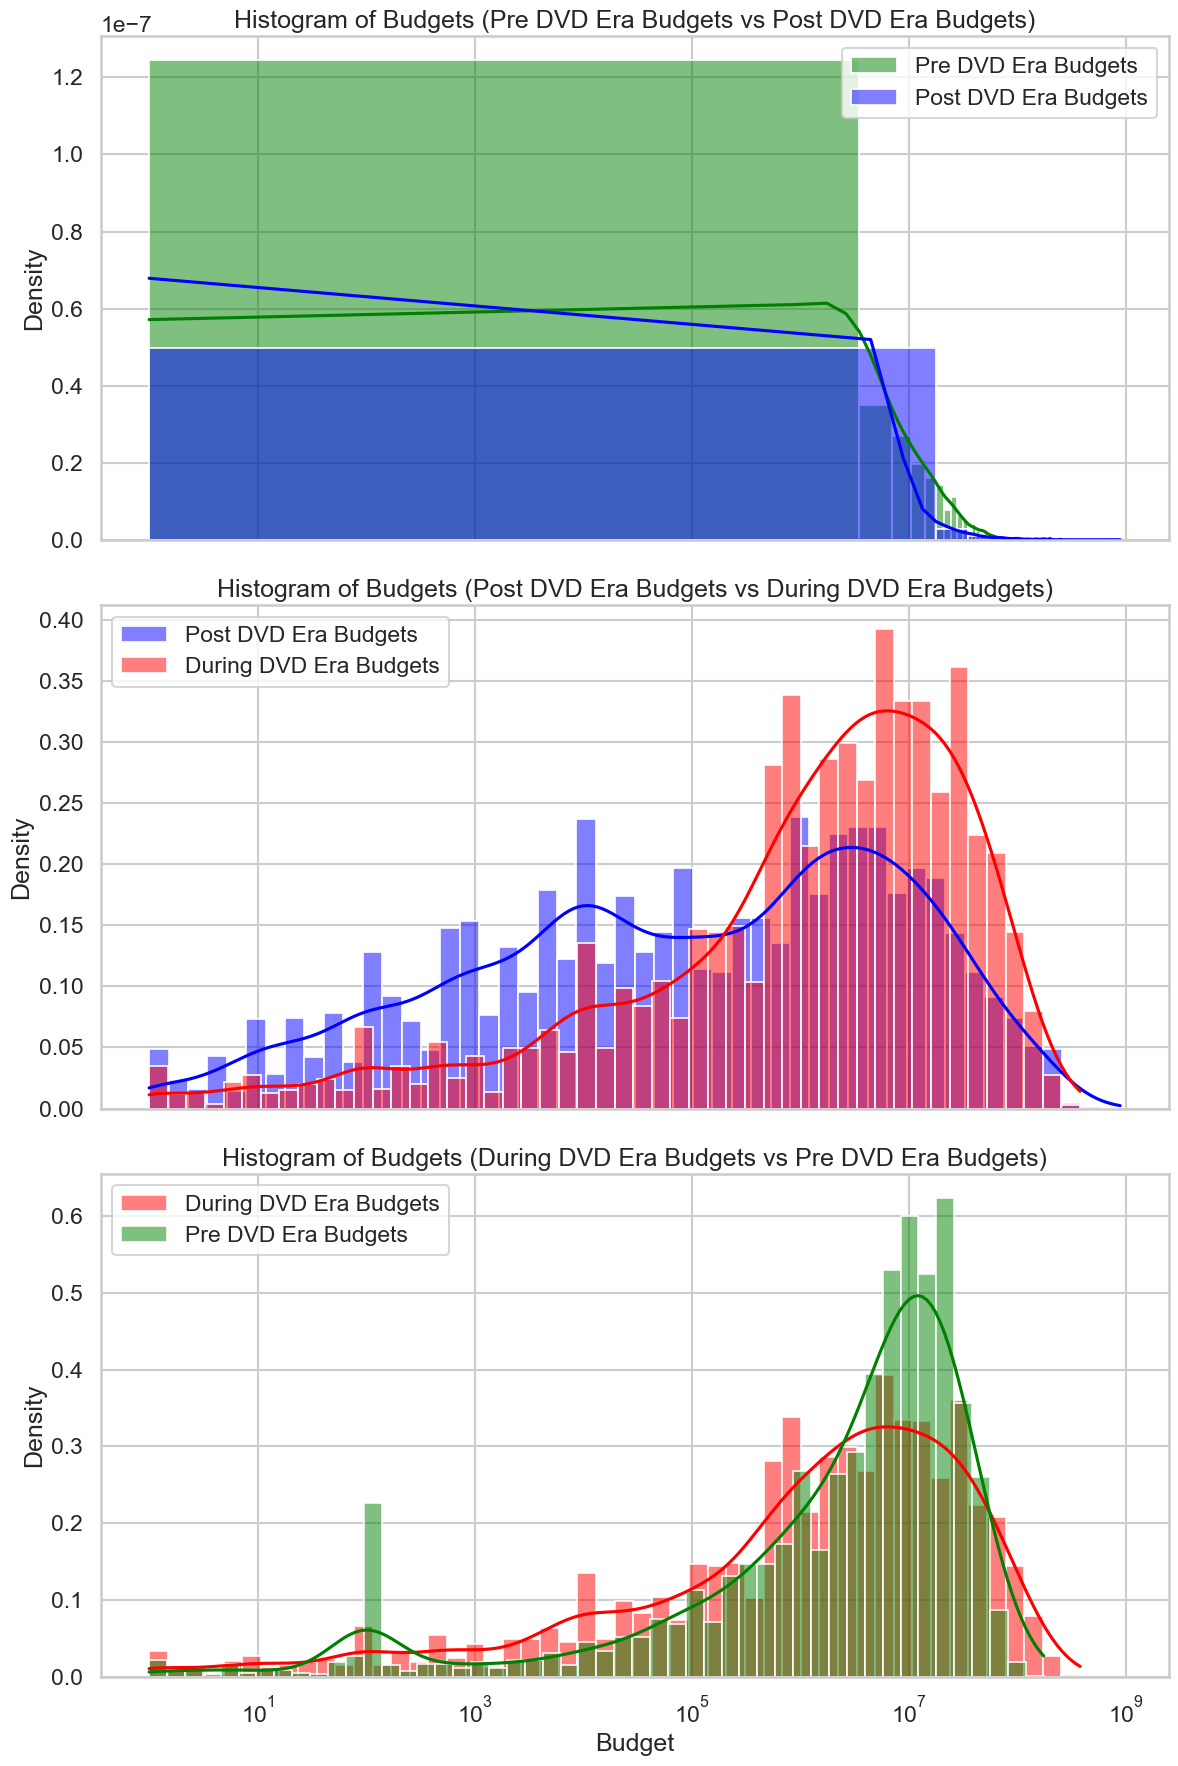

In [15]:

# Define eras, colors, and labels for the plots
eras = [("pre", "post"), ("post", "during"), ("during", "pre")]
colors = [('green', 'blue'), ('blue', 'red'), ('red', 'green')]
labels = [('Pre DVD Era Budgets', 'Post DVD Era Budgets'), 
          ('Post DVD Era Budgets', 'During DVD Era Budgets'), 
          ('During DVD Era Budgets', 'Pre DVD Era Budgets')]

# Plot histograms
plot_budget_histograms(df_filtered, eras, colors, labels, 'Histogram of Budgets')

## Production types

We categorize the movies in different types according to their budgets (compared to the mean) :
- Independent movies: less than 1/10th of the mean budget.
- Small productions: Between 1/10th and 1 of the mean budget.
- Big productions: Between 1 and 5 times the mean budget.
- Super productions More than 5 times the mean budget.

We then plot the proportion of those movies (over the total) using a 3 years rolling average.

The most interesting finding is that the DVD era seems to correspond to a loss of interest for really expensive movies. This can be explained by the fact that :
- Before DVDs, going to the cinema was exceptional, but also the only way to consume movies. So only big franchises with high production budgets could really make a lot of profit.
- After DVDs, the streaming platforms want to differentiate from each other by giving access to exceptional movies, that are really costly.

/Users/charlottemeyer/Documents/EPFL - Applied Data Analysis/ada-2024-project-databand/src/utils/data_utils.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'budget_category'] = df.apply(categorize_budget, args=(budget_stats,), axis=1)


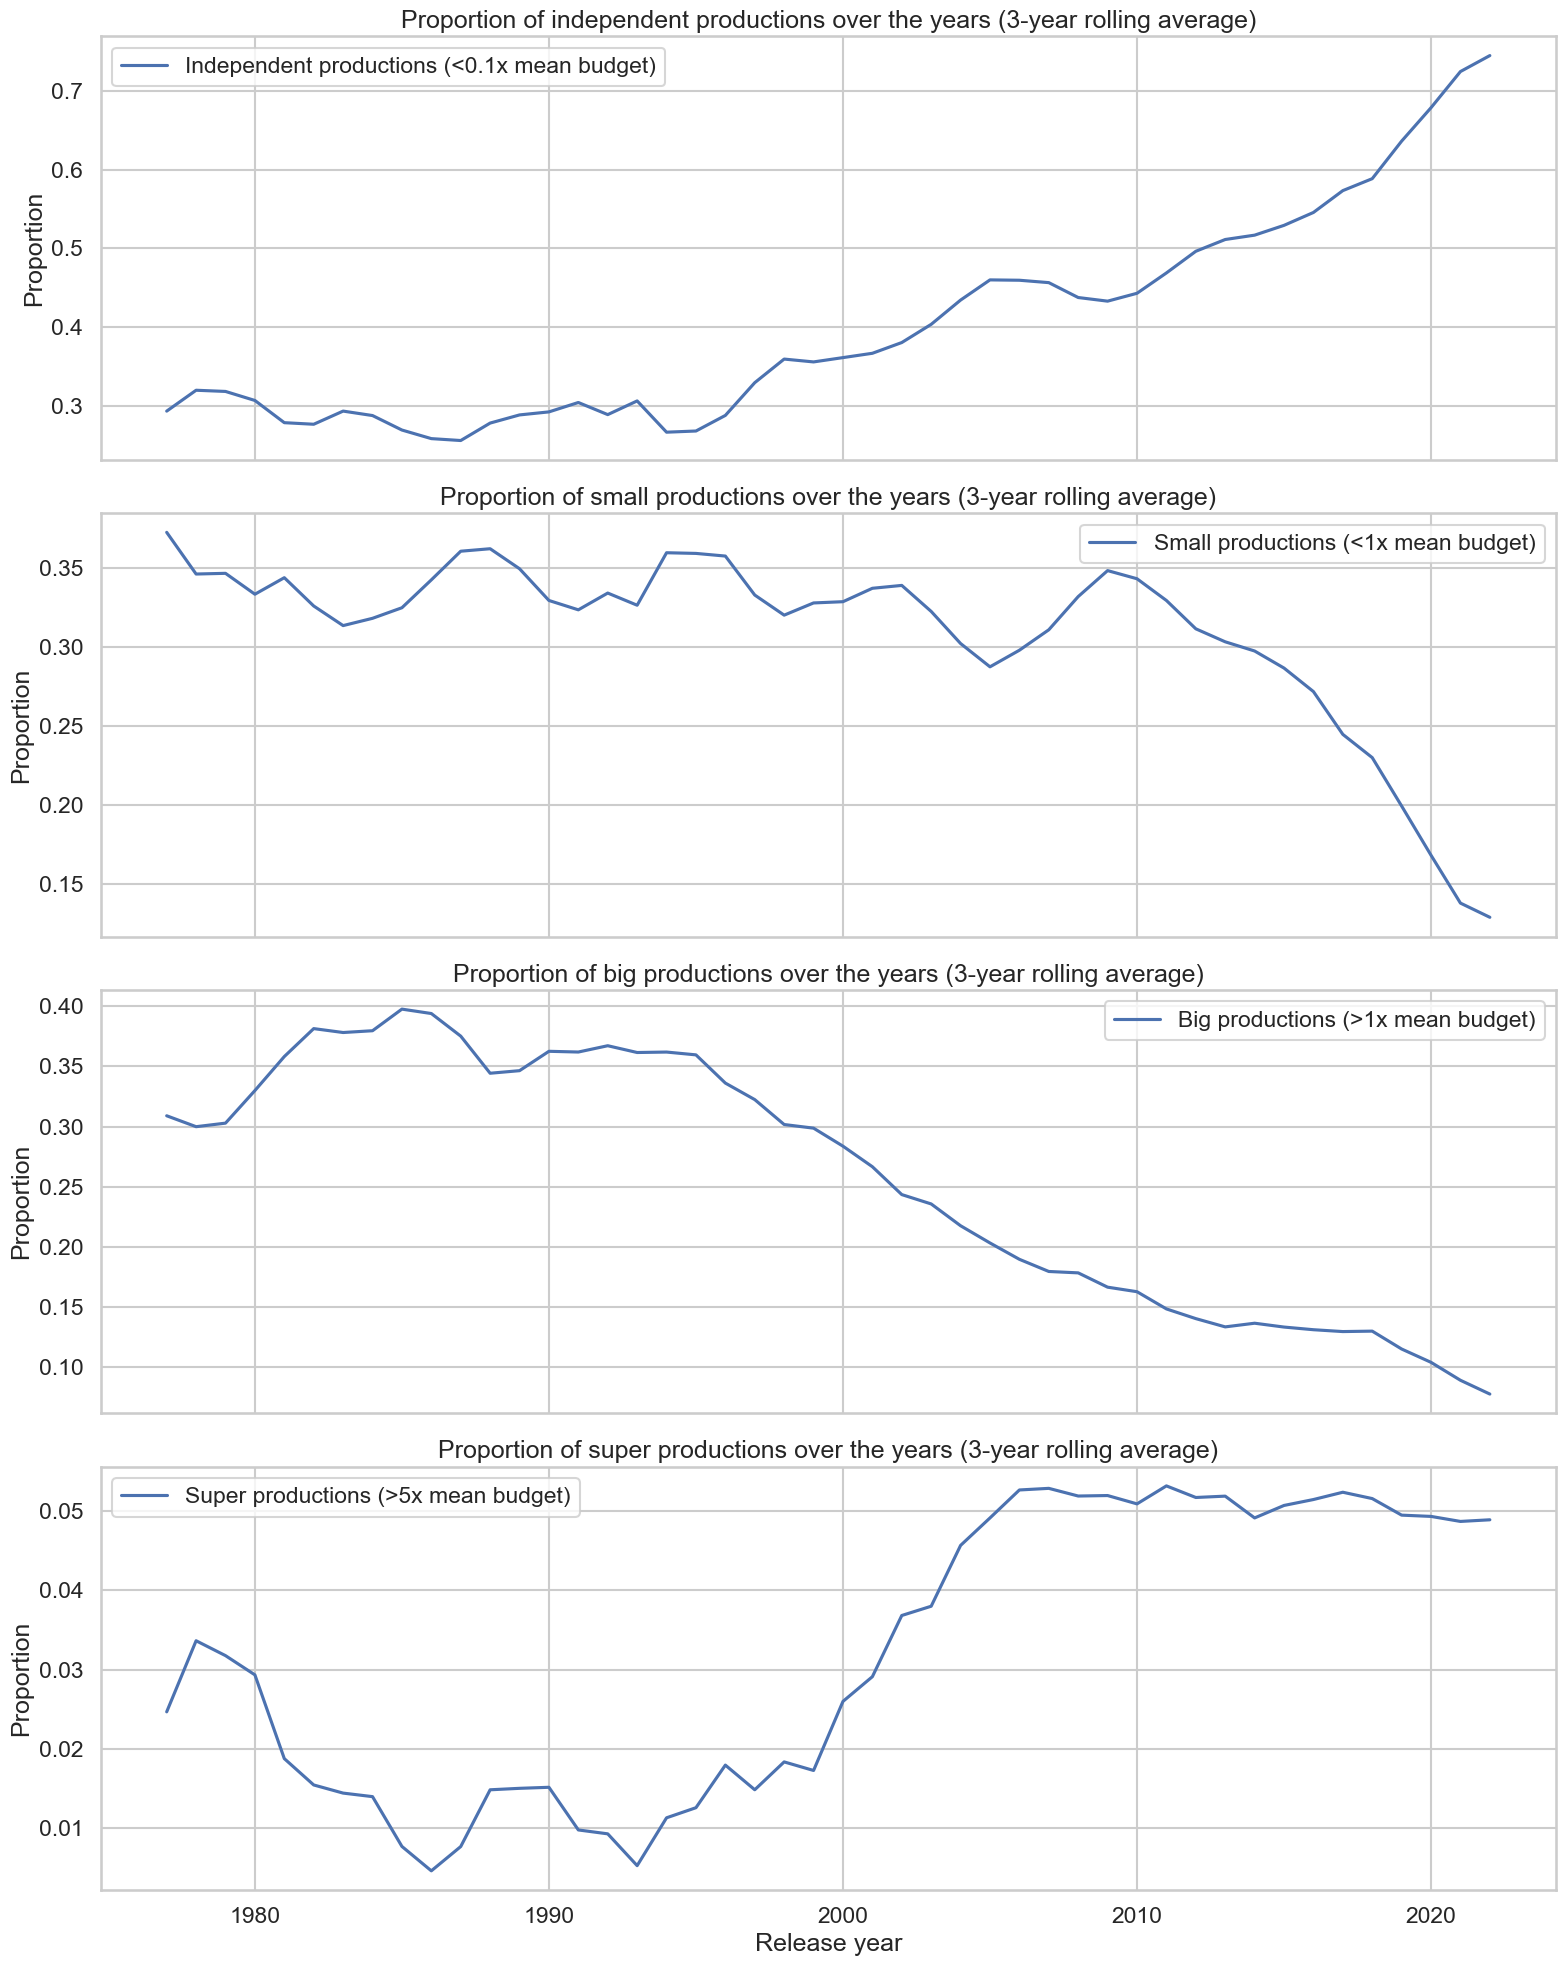

In [16]:
prop_rolling_avg = budget_rolling_averages(df_filtered, window=3)
plot_rolling_averages(prop_rolling_avg)

# Production Companies

We then take a look at production companies

In [17]:
df['budget']


0         160000000
1         165000000
2         185000000
3         237000000
4         220000000
            ...    
455144            0
455145            0
455146            0
455147            0
455149            0
Name: budget, Length: 363442, dtype: int64

In [18]:
def calculate_roi(df):
    if df.revenue > 0 and df.budget > 0:
        return (df.revenue - df.budget) / df.budget * 100
    else: 
        return 0
    
df['roi'] = df.apply(calculate_roi, axis=1)

In [19]:
mean_budgets = df[df.budget > 0].groupby('release_year').agg(mean_budget = ('budget', 'mean'))

def categorize_production(row, means):
    mean_budget = means.loc[row.release_year, 'mean_budget']
    if row['budget'] < 0.1 * mean_budget:
        return 'Independent'
    elif row['budget'] < mean_budget:
        return 'Small'
    elif row['budget'] < 5 * mean_budget:
        return 'Big'
    else:
        return 'Super'
    
df['prod_type'] = df.apply(categorize_production, axis=1, args=(mean_budgets,))

<Axes: xlabel='release_year', ylabel='mean_roi'>

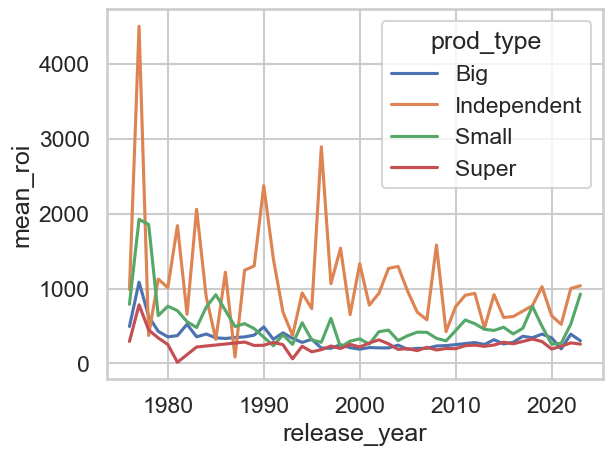

In [20]:
sns.lineplot(
    df[(df.roi > 0) & (df.roi <1e4)].groupby(['release_year', 'prod_type']).agg(mean_roi=('roi', 'mean')).reset_index(),
    x='release_year', y='mean_roi', hue='prod_type')

In [21]:
df.head()

title release_date     revenue  runtime     budget  \
0        inception   2010-07-15   825532764      148  160000000   
1     interstellar   2014-11-05   701729206      169  165000000   
2  the dark knight   2008-07-16  1004558444      152  185000000   
3           avatar   2009-12-15  2923706026      162  237000000   
4     the avengers   2012-04-25  1518815515      143  220000000   

  original_language                                           overview  \
0                en  cobb, a skilled thief who commits corporate es...   
1                en  the adventures of a group of explorers who mak...   
2                en  batman raises the stakes in his war on crime. ...   
3                en  in the 22nd century, a paraplegic marine is di...   
4                en  when an unexpected enemy emerges and threatens...   

                                          genres  \
0           [action, science fiction, adventure]   
1            [adventure, drama, science fiction]   
2               [drama, action, crime, thriller]   
3  [action, adventure, fantasy, science fiction]   
4           [science fiction, action, adventure]   

                                production_companies  \
0  [legendary pictures, syncopy, warner bros. pic...   
1  [legendary pictures, syncopy, lynda obst produ...   
2  [dc comics, legendary pictures, syncopy, isobe...   
3  [dune entertainment, lightstorm entertainment,...   
4                                   [marvel studios]   

                         production_countries  \
0  [united kingdom, united states of america]   
1  [united kingdom, united states of america]   
2  [united kingdom, united states of america]   
3  [united states of america, united kingdom]   
4                  [united states of america]   

                       spoken_languages  \
0  [english, french, japanese, swahili]   
1                             [english]   
2                   [english, mandarin]   
3                    [english, spanish]   
4             [english, hindi, russian]   

                                            keywords  release_year dvd_era  \
0  [rescue, mission, dream, airplane, paris, fran...          2010  during   
1  [rescue, future, spacecraft, race against time...          2014    post   
2  [joker, sadism, chaos, secret identity, crime ...          2008  during   
3  [future, society, culture clash, space travel,...          2009  during   
4  [new york city, superhero, shield, based on co...          2012  during   

           roi prod_type  
0   415.957978     Super  
1   325.290428     Super  
2   443.004564     Super  
3  1133.631235     Super  
4   590.370689     Super

In [22]:
from itertools import combinations
import networkx as nx

In [23]:
def create_edges_list(df):
    edges = []
    for companies in df['production_companies']:
        if len(companies)>1:
            edges.extend(list(combinations(companies,2)))
    # edges = list(set(edges))
    return edges


In [24]:
df_graph = df[df['production_companies'].str.len() > 0]

before_DVD_era_super = df_graph[(df_graph['dvd_era'] == 'pre') & (df_graph['prod_type'] == 'Super')]
# during_DVD_era = df_graph[df_graph['dvd_era'] == 'during']
# after_DVD_era = df_graph[df_graph['dvd_era'] == 'post']

print(before_DVD_era_super.shape)
# print(during_DVD_era.shape)
# print(after_DVD_era.shape)



(43, 16)


In [25]:
before_edges = create_edges_list(before_DVD_era_super)
# during_edges = create_edges_list(during_DVD_era)
# after_edges = create_edges_list(after_DVD_era)

In [26]:
before_edges[0]


('lightstorm entertainment', 'carolco pictures')

In [27]:

# Create the graph
G_before = nx.Graph()
# G_during = nx.Graph()
# G_after = nx.Graph()

G_before.add_edges_from(before_edges)
# G_during.add_edges_from(during_edges)
# G_after.add_edges_from(after_edges)


In [28]:
from ipywidgets import interact, widgets, IntSlider, Layout
import matplotlib.pyplot as plt
import networkx as nx

@interact(
    year=IntSlider(
        min=1976,
        max=2023,
        step=1,
        value=2000,
        description='Year:',
        continuous_update=False,
        layout=Layout(width='50%')
    ),
    prod_type=widgets.Dropdown(
        options=['Super', 'Big', 'Small', 'Independent'],
        value='Super',
        description='Production Type:'
    )
)
def plot_network_by_year(year, prod_type):
    # Clear previous plot
    plt.clf()
    
    # Filter data
    df_filtered = df_graph[
        (df_graph['release_year'].astype(int) == year) & 
        (df_graph['prod_type'] == prod_type)
    ]
    
    # Create edges list
    edges = create_edges_list(df_filtered)
    
    # Create network
    G = nx.Graph()
    G.add_edges_from(edges)
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Calculate network layout
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Draw the network
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color='lightblue',
        node_size=1000,
        font_size=8,
        font_weight='bold',
        edge_color='gray',
        width=0.5,
        alpha=0.7
    )
    
    # Add title with statistics
    plt.title(f"Production Company Network - {year} ({prod_type} Productions)\n" +
              f"Companies: {G.number_of_nodes()}, " +
              f"Collaborations: {G.number_of_edges()}, " +
              f"Avg. Collaborations per Company: {2*G.number_of_edges()/G.number_of_nodes():.2f}" if G.number_of_nodes() > 0 else "No data",
              pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print additional statistics
    if G.number_of_nodes() > 0:
        print("\nTop 5 Companies by Number of Collaborations:")
        degrees = dict(G.degree())
        top_companies = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]
        for company, degree in top_companies:
            print(f"{company}: {degree} collaborations")

interactive(children=(IntSlider(value=2000, continuous_update=False, description='Year:', layout=Layout(width=…

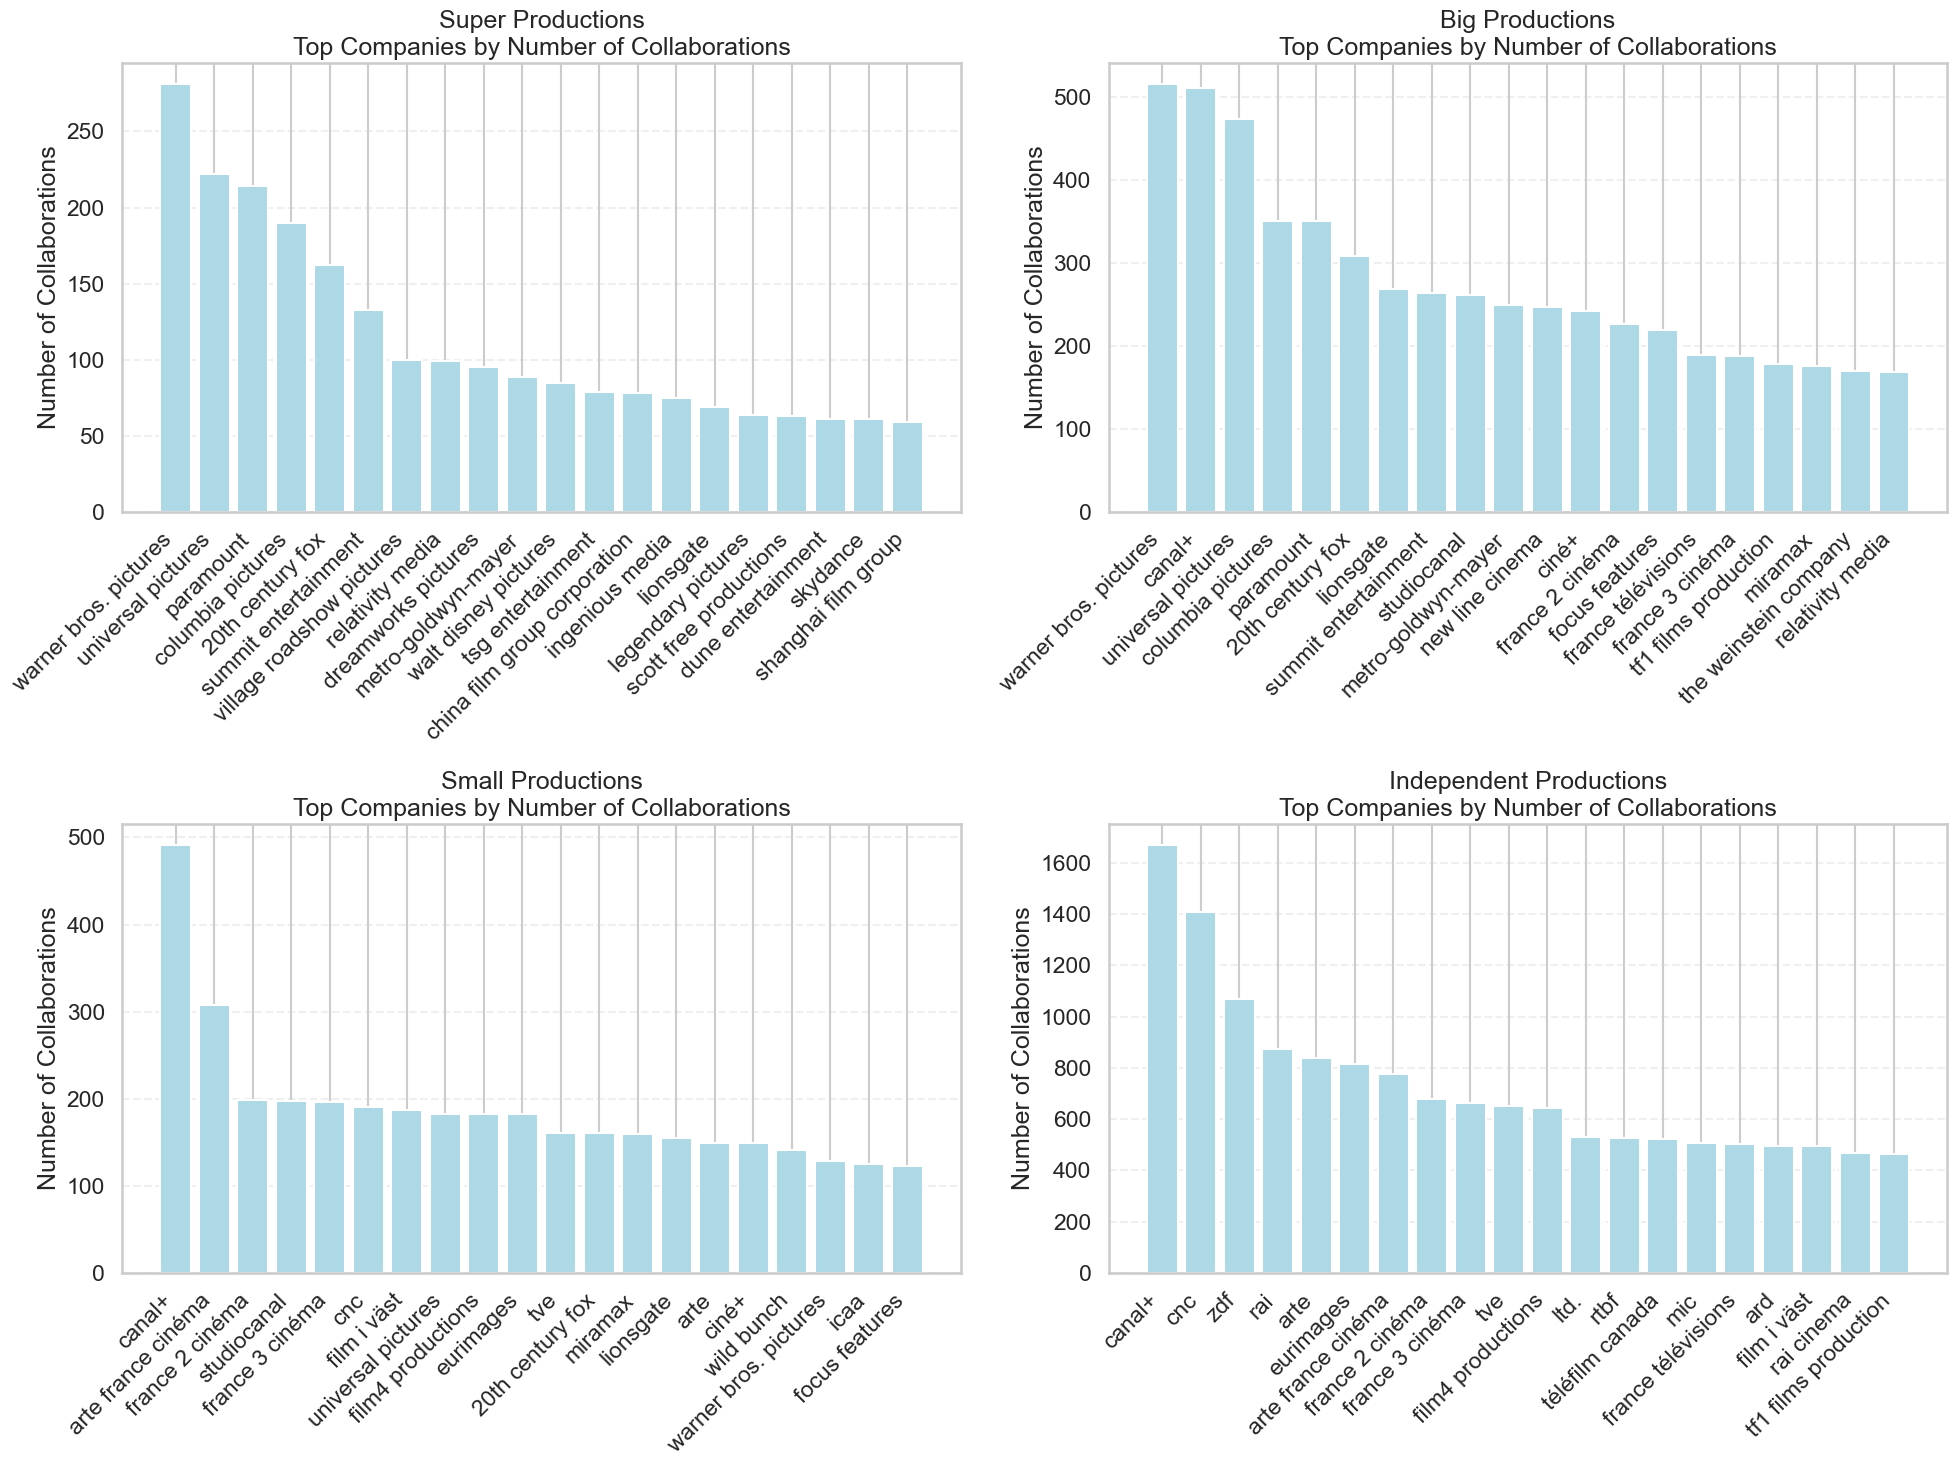


Super Productions Summary:
Total companies: 1378
Average collaborations per company: 10.21

Top 5 most collaborative companies:
warner bros. pictures: 281 collaborations
universal pictures: 222 collaborations
paramount: 214 collaborations
columbia pictures: 190 collaborations
20th century fox: 162 collaborations

Big Productions Summary:
Total companies: 4952
Average collaborations per company: 10.34

Top 5 most collaborative companies:
warner bros. pictures: 515 collaborations
canal+: 510 collaborations
universal pictures: 473 collaborations
columbia pictures: 351 collaborations
paramount: 350 collaborations

Small Productions Summary:
Total companies: 7911
Average collaborations per company: 7.04

Top 5 most collaborative companies:
canal+: 491 collaborations
arte france cinéma: 308 collaborations
france 2 cinéma: 199 collaborations
studiocanal: 197 collaborations
france 3 cinéma: 196 collaborations

Independent Productions Summary:
Total companies: 56442
Average collaborations per 

In [45]:
# Create a figure with subplots for each production type
plt.figure(figsize=(20, 15))

# Define production types
production_types = ['Super', 'Big', 'Small', 'Independent']

# Create subplot for each production type
for idx, prod_type in enumerate(production_types, 1):
    plt.subplot(2, 2, idx)
    
    # Filter data for this production type
    df_filtered = df_graph[df_graph['prod_type'] == prod_type]
    
    # Create edges list
    edges = create_edges_list(df_filtered)
    
    # Create network
    G = nx.Graph()
    G.add_edges_from(edges)
    
    # Get degree (number of collaborations) for each company
    degrees = dict(G.degree())
    
    # Sort companies by number of collaborations
    sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:20]  # Top 20 companies
    companies, num_collabs = zip(*sorted_degrees) if sorted_degrees else ([], [])
    
    # Create bar plot
    plt.bar(range(len(companies)), num_collabs, color='lightblue')
    plt.xticks(range(len(companies)), companies, rotation=45, ha='right')
    
    # Add labels and title
    plt.title(f'{prod_type} Productions\nTop Companies by Number of Collaborations')
    plt.ylabel('Number of Collaborations')
    
    # Add grid for better readability
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics for each production type
for prod_type in production_types:
    df_filtered = df_graph[df_graph['prod_type'] == prod_type]
    edges = create_edges_list(df_filtered)
    G = nx.Graph()
    G.add_edges_from(edges)
    degrees = dict(G.degree())
    
    print(f"\n{prod_type} Productions Summary:")
    print(f"Total companies: {len(degrees)}")
    print(f"Average collaborations per company: {sum(degrees.values())/len(degrees):.2f}")
    print("\nTop 5 most collaborative companies:")
    top_5 = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]
    for company, collabs in top_5:
        print(f"{company}: {collabs} collaborations")

        

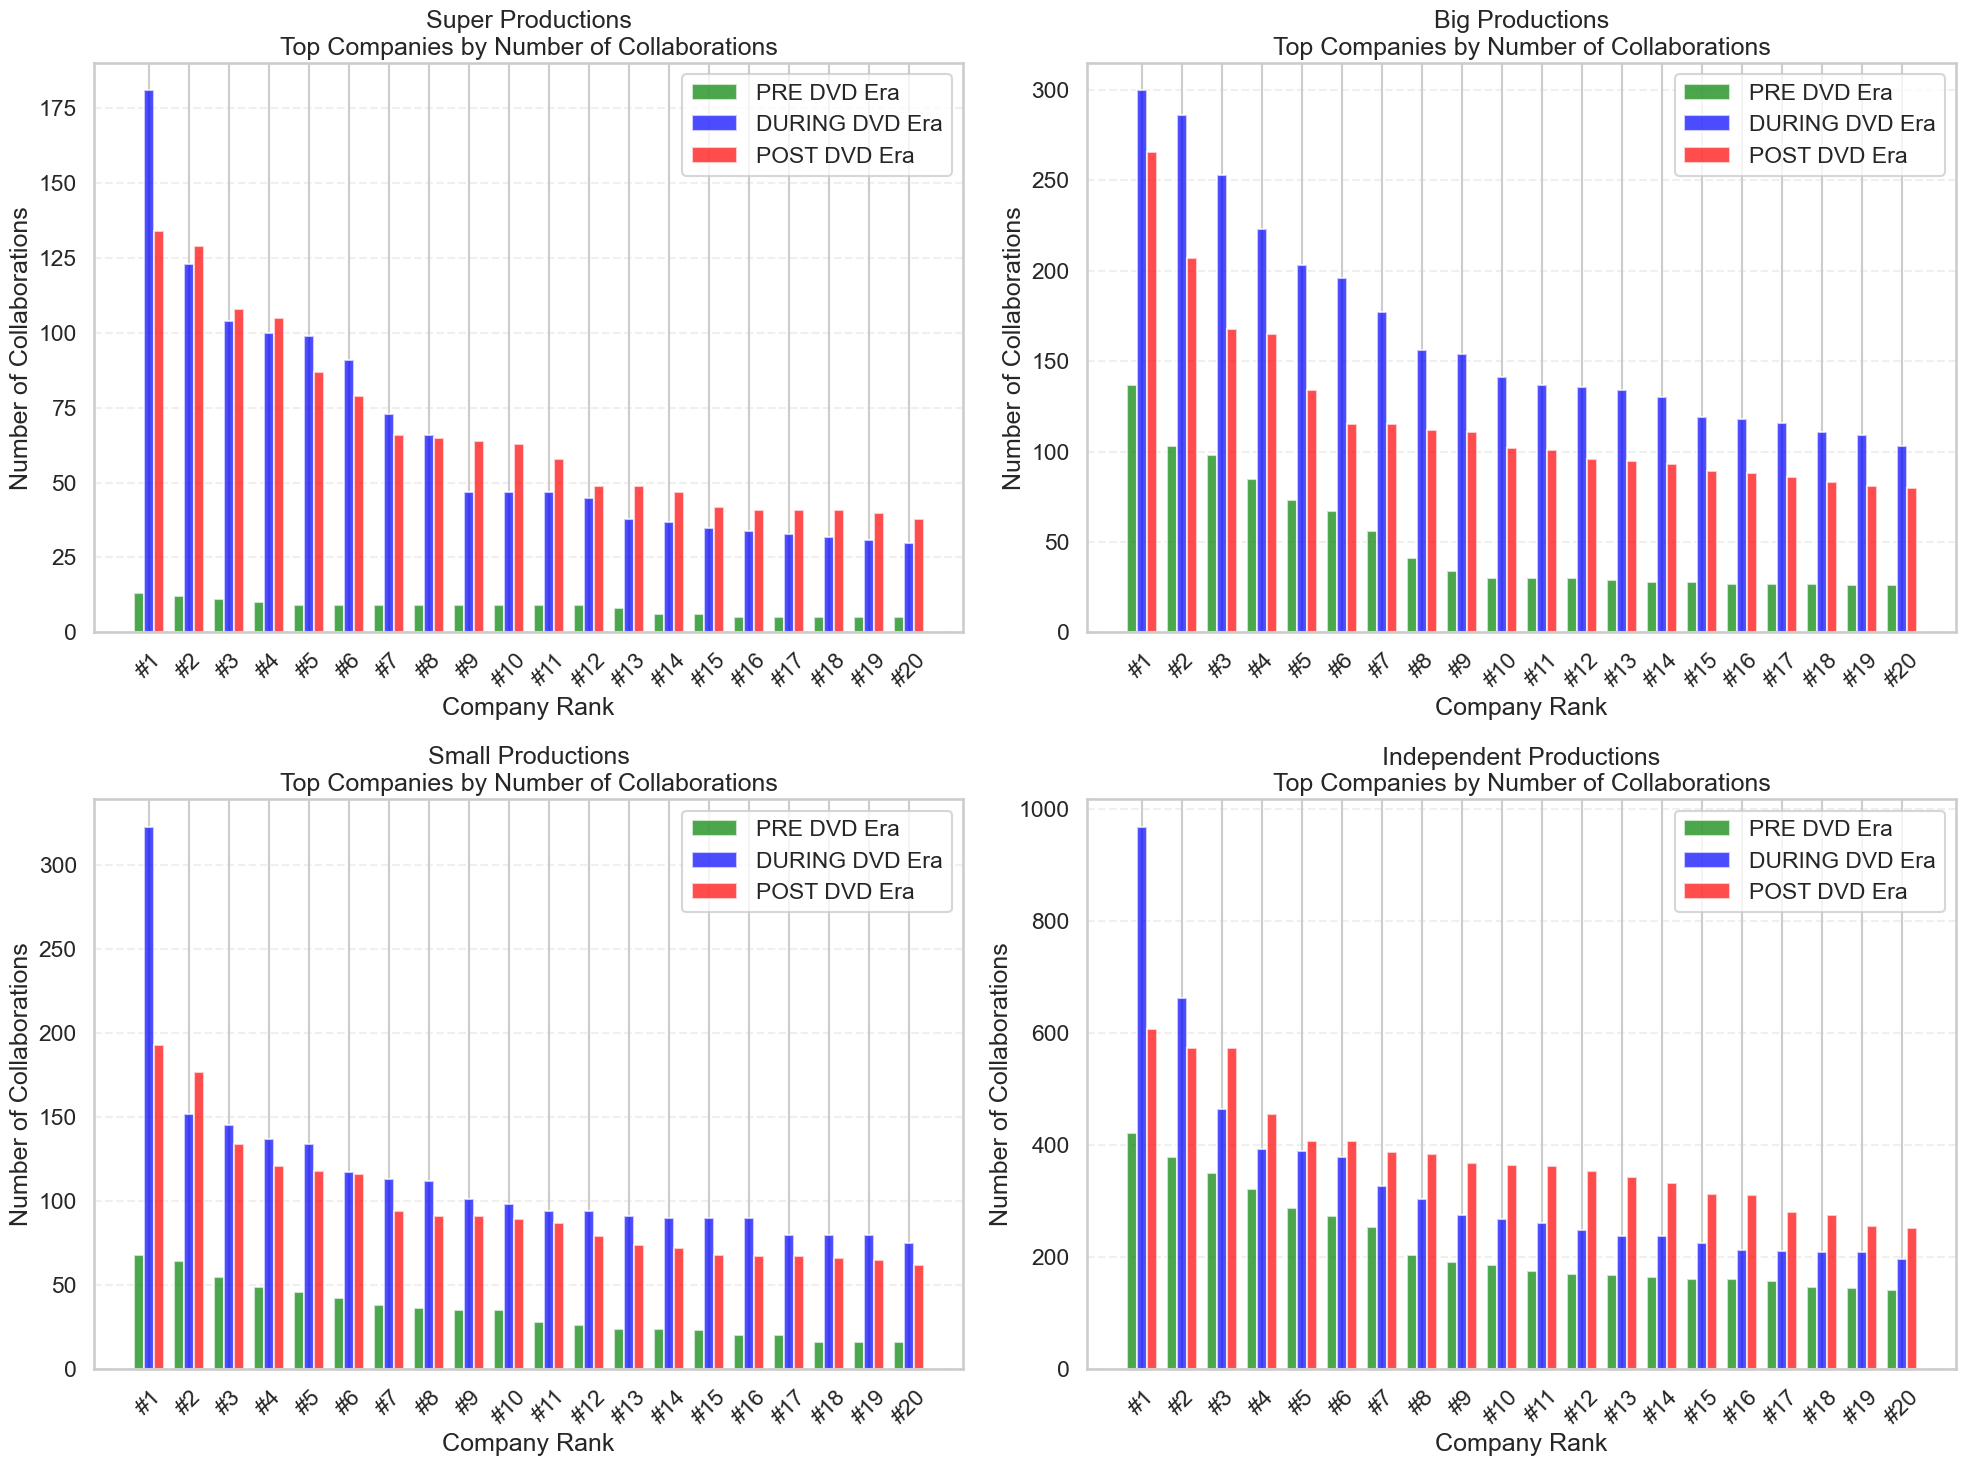


Super Productions Summary:

PRE DVD Era:
Total companies: 72
Average collaborations: 3.92
Top 3 companies:
  carolco pictures: 13 collaborations
  metro-goldwyn-mayer: 12 collaborations
  warner bros. pictures: 11 collaborations

DURING DVD Era:
Total companies: 662
Average collaborations: 9.75
Top 3 companies:
  warner bros. pictures: 181 collaborations
  universal pictures: 123 collaborations
  columbia pictures: 104 collaborations

POST DVD Era:
Total companies: 871
Average collaborations: 9.07
Top 3 companies:
  warner bros. pictures: 134 collaborations
  paramount: 129 collaborations
  universal pictures: 108 collaborations

Big Productions Summary:

PRE DVD Era:
Total companies: 804
Average collaborations: 5.50
Top 3 companies:
  warner bros. pictures: 137 collaborations
  universal pictures: 103 collaborations
  columbia pictures: 98 collaborations

DURING DVD Era:
Total companies: 2609
Average collaborations: 10.07
Top 3 companies:
  warner bros. pictures: 300 collaborations
 

In [47]:
# Create a figure with subplots for each production type
plt.figure(figsize=(20, 15))

# Define eras and production types
eras = ['pre', 'during', 'post']
production_types = ['Super', 'Big', 'Small', 'Independent']
colors = ['green', 'blue', 'red']  # One color for each era

# Create subplot for each production type
for prod_idx, prod_type in enumerate(production_types, 1):
    plt.subplot(2, 2, prod_idx)
    
    # Get collaboration data for each era
    era_data = []
    max_companies = 0
    
    for era in eras:
        # Filter data for this era and production type
        df_filtered = df_graph[
            (df_graph['dvd_era'] == era) & 
            (df_graph['prod_type'] == prod_type)
        ]
        
        # Create edges list and network
        edges = create_edges_list(df_filtered)
        G = nx.Graph()
        G.add_edges_from(edges)
        
        # Get and sort collaborations
        degrees = dict(G.degree())
        sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:20]  # Top 20
        era_data.append(sorted_degrees)
        max_companies = max(max_companies, len(sorted_degrees))
    
    # Plot grouped bars
    bar_width = 0.25
    r1 = np.arange(max_companies)
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    
    # Create bars for each era
    for idx, (era_degrees, r, color) in enumerate(zip(era_data, [r1, r2, r3], colors)):
        companies, collabs = zip(*era_degrees) if era_degrees else ([], [])
        plt.bar(r[:len(collabs)], collabs, 
               width=bar_width, 
               label=f'{eras[idx].upper()} DVD Era',
               color=color,
               alpha=0.7)
    
    # Add labels and customize plot
    plt.title(f'{prod_type} Productions\nTop Companies by Number of Collaborations')
    plt.xlabel('Company Rank')
    plt.ylabel('Number of Collaborations')
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    
    # Adjust x-axis
    plt.xticks([r + bar_width for r in range(max_companies)], 
               [f'#{i+1}' for i in range(max_companies)],
               rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
for prod_type in production_types:
    print(f"\n{prod_type} Productions Summary:")
    for era in eras:
        df_filtered = df_graph[
            (df_graph['dvd_era'] == era) & 
            (df_graph['prod_type'] == prod_type)
        ]
        edges = create_edges_list(df_filtered)
        G = nx.Graph()
        G.add_edges_from(edges)
        degrees = dict(G.degree())
        
        if len(degrees) > 0:
            print(f"\n{era.upper()} DVD Era:")
            print(f"Total companies: {len(degrees)}")
            print(f"Average collaborations: {sum(degrees.values())/len(degrees):.2f}")
            print("Top 3 companies:")
            top_3 = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:3]
            for company, collabs in top_3:
                print(f"  {company}: {collabs} collaborations")

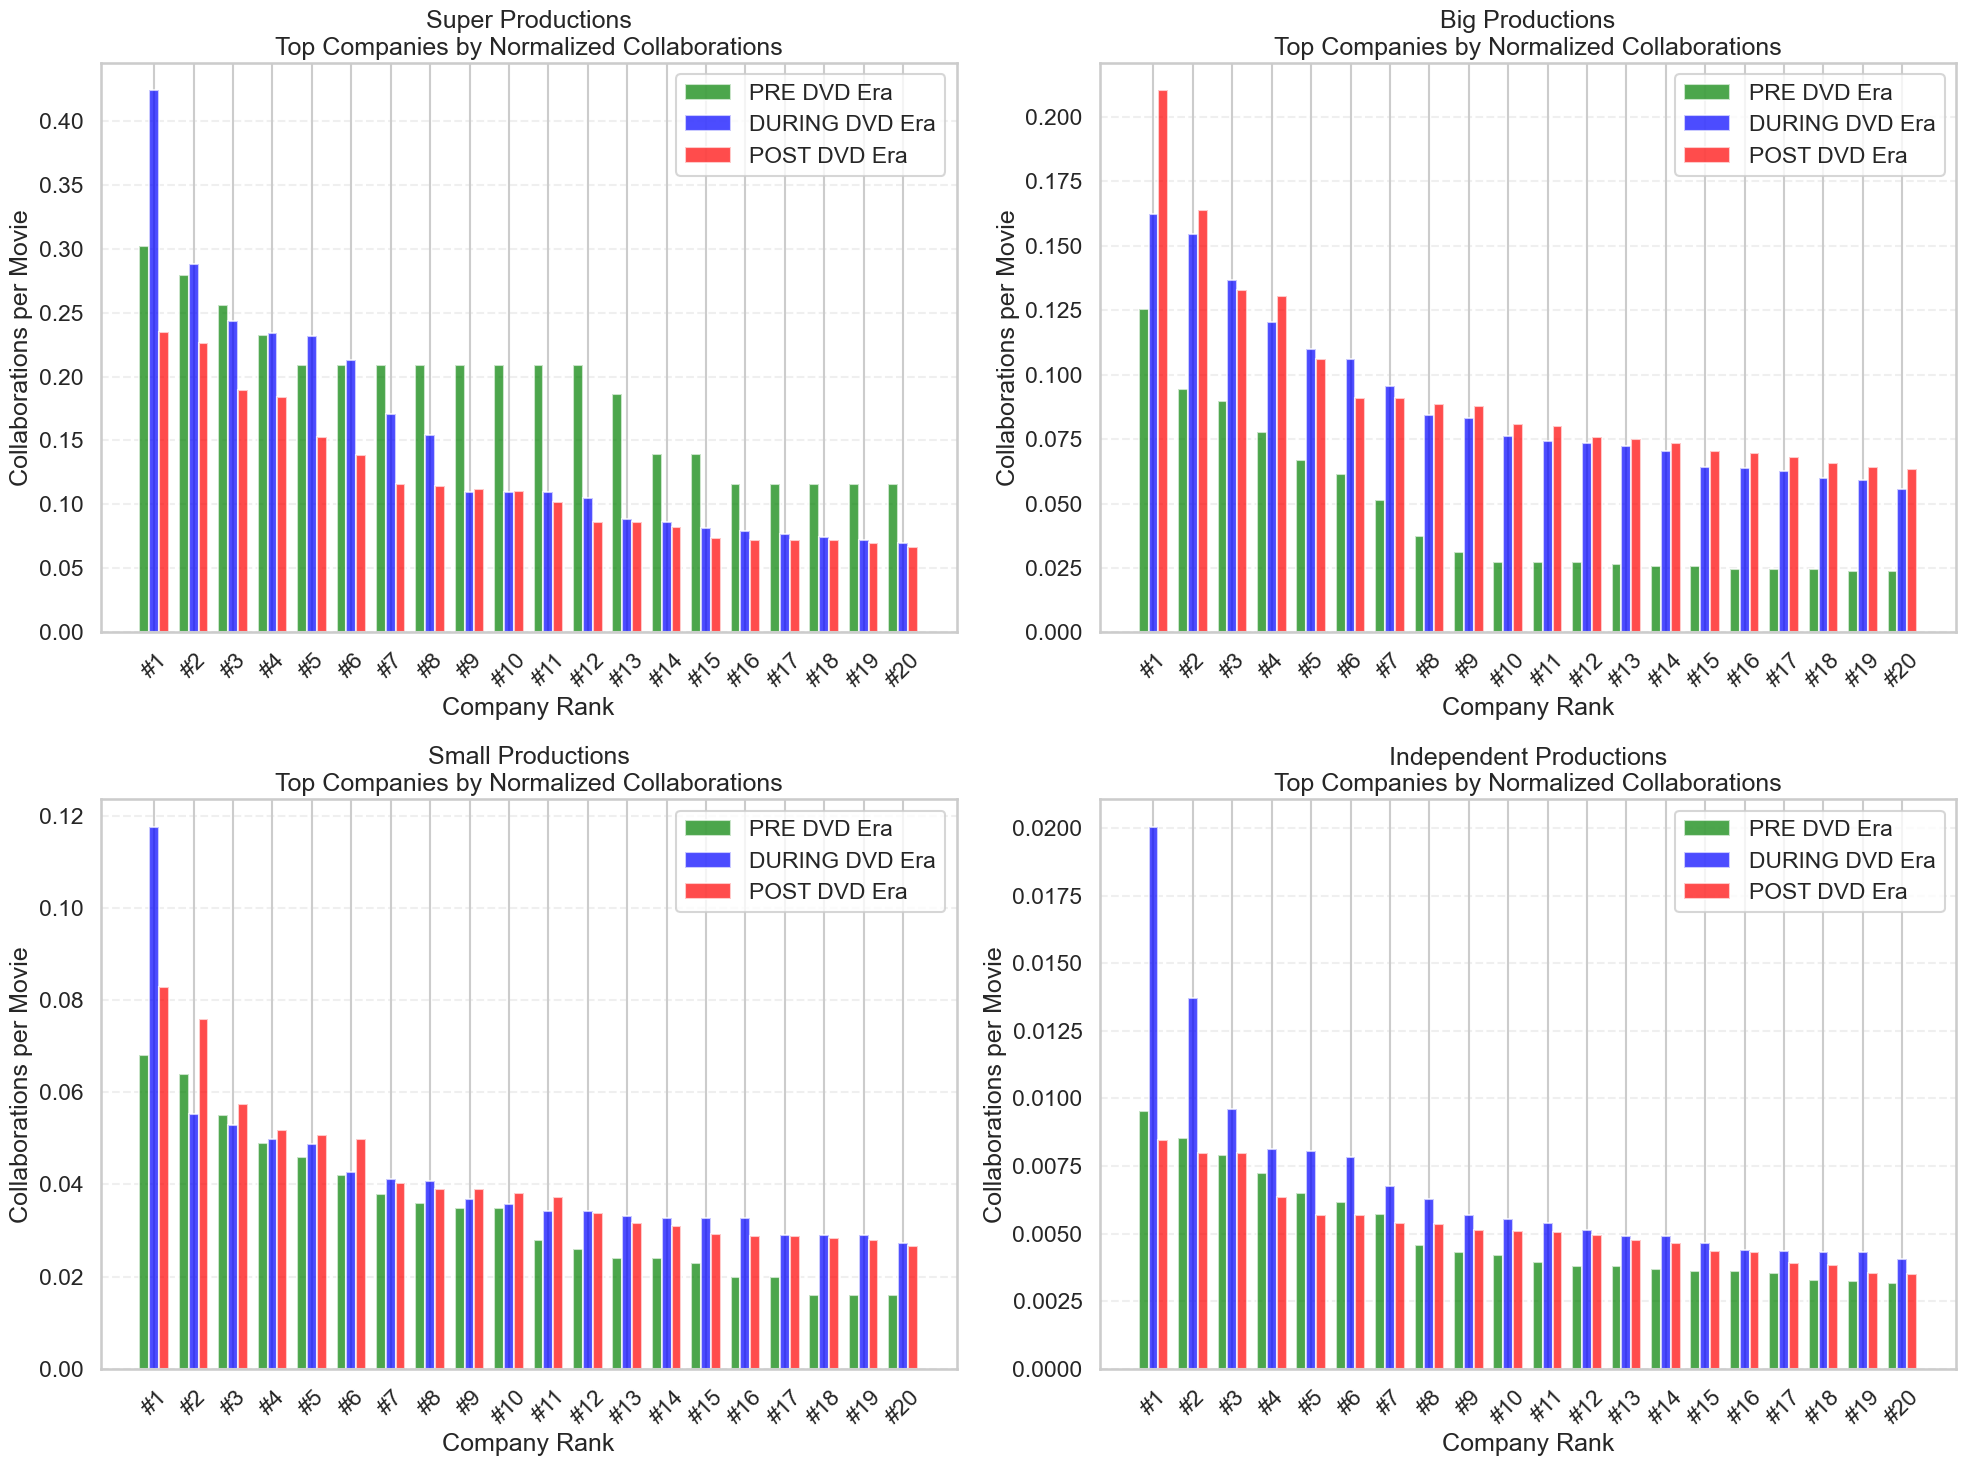


Super Productions Summary:

PRE DVD Era:
Total movies: 43
Total companies: 72
Average collaborations per movie: 6.56
Top 3 companies (collaborations per movie):
  carolco pictures: 0.302 collaborations per movie
  metro-goldwyn-mayer: 0.279 collaborations per movie
  warner bros. pictures: 0.256 collaborations per movie

DURING DVD Era:
Total movies: 427
Total companies: 662
Average collaborations per movie: 15.11
Top 3 companies (collaborations per movie):
  warner bros. pictures: 0.424 collaborations per movie
  universal pictures: 0.288 collaborations per movie
  columbia pictures: 0.244 collaborations per movie

POST DVD Era:
Total movies: 570
Total companies: 871
Average collaborations per movie: 13.86
Top 3 companies (collaborations per movie):
  warner bros. pictures: 0.235 collaborations per movie
  paramount: 0.226 collaborations per movie
  universal pictures: 0.189 collaborations per movie

Big Productions Summary:

PRE DVD Era:
Total movies: 1091
Total companies: 804
Avera

In [48]:
# Create a figure with subplots for each production type
plt.figure(figsize=(20, 15))

# Define eras and production types
eras = ['pre', 'during', 'post']
production_types = ['Super', 'Big', 'Small', 'Independent']
colors = ['green', 'blue', 'red']  # One color for each era

# Create subplot for each production type
for prod_idx, prod_type in enumerate(production_types, 1):
    plt.subplot(2, 2, prod_idx)
    
    # Get collaboration data for each era
    era_data = []
    max_companies = 0
    
    for era in eras:
        # Filter data for this era and production type
        df_filtered = df_graph[
            (df_graph['dvd_era'] == era) & 
            (df_graph['prod_type'] == prod_type)
        ]
        
        # Get total number of movies for this era and production type
        total_movies = len(df_filtered)
        
        # Create edges list and network
        edges = create_edges_list(df_filtered)
        G = nx.Graph()
        G.add_edges_from(edges)
        
        # Get and sort collaborations, normalized by number of movies
        degrees = dict(G.degree())
        normalized_degrees = [(company, degree/total_movies) for company, degree in degrees.items()]
        sorted_degrees = sorted(normalized_degrees, key=lambda x: x[1], reverse=True)[:20]  # Top 20
        era_data.append(sorted_degrees)
        max_companies = max(max_companies, len(sorted_degrees))
    
    # Plot grouped bars
    bar_width = 0.25
    r1 = np.arange(max_companies)
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    
    # Create bars for each era
    for idx, (era_degrees, r, color) in enumerate(zip(era_data, [r1, r2, r3], colors)):
        companies, collabs = zip(*era_degrees) if era_degrees else ([], [])
        plt.bar(r[:len(collabs)], collabs, 
               width=bar_width, 
               label=f'{eras[idx].upper()} DVD Era',
               color=color,
               alpha=0.7)
    
    # Add labels and customize plot
    plt.title(f'{prod_type} Productions\nTop Companies by Normalized Collaborations')
    plt.xlabel('Company Rank')
    plt.ylabel('Collaborations per Movie')
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    
    # Adjust x-axis
    plt.xticks([r + bar_width for r in range(max_companies)], 
               [f'#{i+1}' for i in range(max_companies)],
               rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
for prod_type in production_types:
    print(f"\n{prod_type} Productions Summary:")
    for era in eras:
        df_filtered = df_graph[
            (df_graph['dvd_era'] == era) & 
            (df_graph['prod_type'] == prod_type)
        ]
        total_movies = len(df_filtered)
        edges = create_edges_list(df_filtered)
        G = nx.Graph()
        G.add_edges_from(edges)
        degrees = dict(G.degree())
        
        if len(degrees) > 0:
            normalized_degrees = {k: v/total_movies for k, v in degrees.items()}
            print(f"\n{era.upper()} DVD Era:")
            print(f"Total movies: {total_movies}")
            print(f"Total companies: {len(degrees)}")
            print(f"Average collaborations per movie: {sum(degrees.values())/total_movies:.2f}")
            print("Top 3 companies (collaborations per movie):")
            top_3 = sorted(normalized_degrees.items(), key=lambda x: x[1], reverse=True)[:3]
            for company, collabs in top_3:
                print(f"  {company}: {collabs:.3f} collaborations per movie")

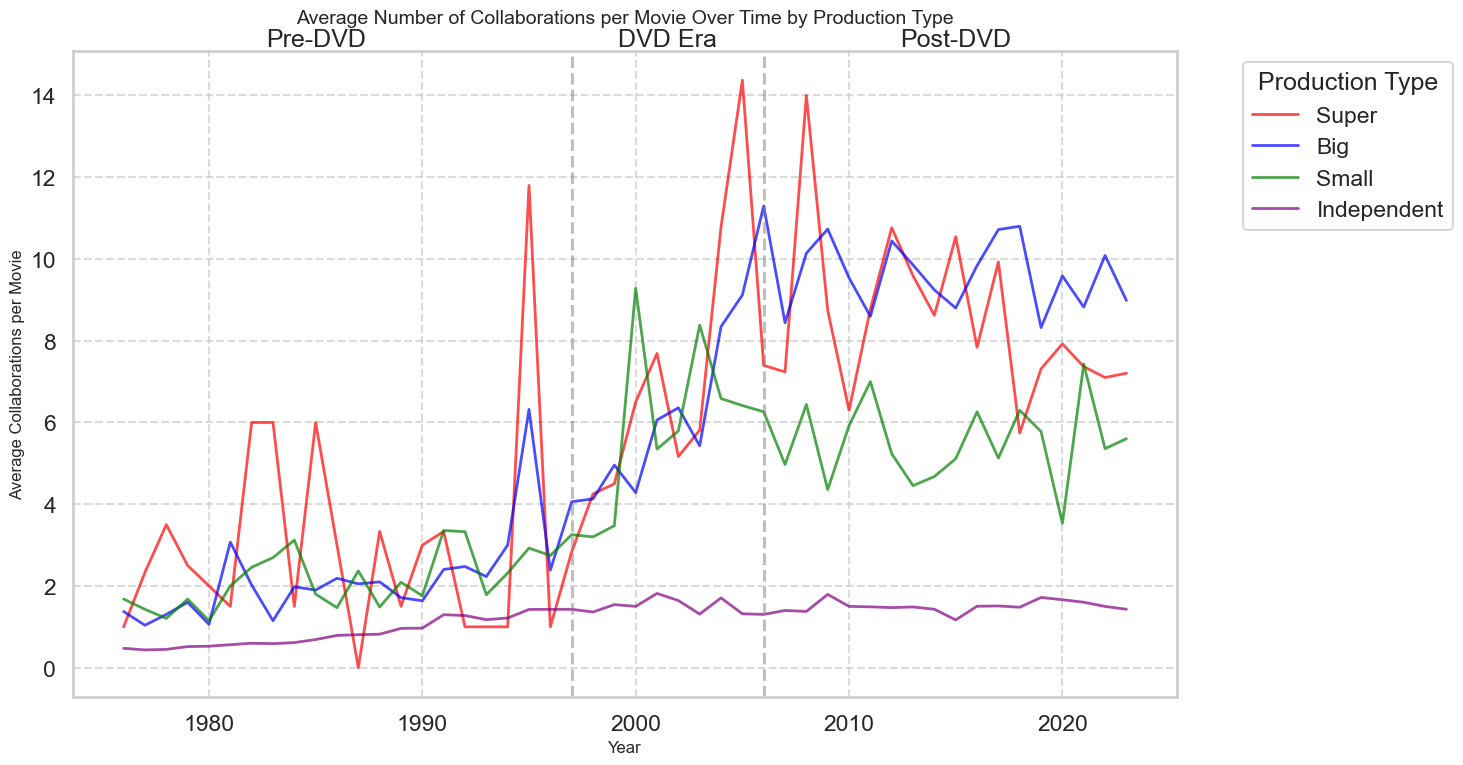


Super Productions Summary:

PRE DVD Era:
Total movies: 43
Average collaborations per movie: 3.28

DURING DVD Era:
Total movies: 427
Average collaborations per movie: 7.56

POST DVD Era:
Total movies: 570
Average collaborations per movie: 6.93

Big Productions Summary:

PRE DVD Era:
Total movies: 1091
Average collaborations per movie: 2.03

DURING DVD Era:
Total movies: 1849
Average collaborations per movie: 7.10

POST DVD Era:
Total movies: 1264
Average collaborations per movie: 8.75

Small Productions Summary:

PRE DVD Era:
Total movies: 1000
Average collaborations per movie: 2.08

DURING DVD Era:
Total movies: 2746
Average collaborations per movie: 5.35

POST DVD Era:
Total movies: 2331
Average collaborations per movie: 5.00

Independent Productions Summary:

PRE DVD Era:
Total movies: 44335
Average collaborations per movie: 0.71

DURING DVD Era:
Total movies: 48326
Average collaborations per movie: 1.27

POST DVD Era:
Total movies: 71765
Average collaborations per movie: 1.29


In [49]:
# Create figure
plt.figure(figsize=(15, 8))

# Define production types and colors for better visualization
production_types = ['Super', 'Big', 'Small', 'Independent']
colors = ['red', 'blue', 'green', 'purple']

# For each production type
for prod_type, color in zip(production_types, colors):
    # Group by year and calculate average collaborations
    yearly_data = []
    years = sorted(df_graph['release_year'].unique())
    
    for year in years:
        # Filter data for this year and production type
        df_filtered = df_graph[
            (df_graph['release_year'] == year) & 
            (df_graph['prod_type'] == prod_type)
        ]
        
        # Get total number of movies for normalization
        total_movies = len(df_filtered)
        
        if total_movies > 0:  # Only process if there are movies
            # Create network
            edges = create_edges_list(df_filtered)
            G = nx.Graph()
            G.add_edges_from(edges)
            
            # Calculate average collaborations normalized by number of movies
            if G.number_of_nodes() > 0:
                avg_collaborations = G.number_of_edges() / total_movies
            else:
                avg_collaborations = 0
                
            yearly_data.append((year, avg_collaborations))
    
    # Convert to arrays for plotting
    years, avg_collabs = zip(*yearly_data)
    
    # Plot line
    plt.plot(years, avg_collabs, label=prod_type, color=color, linewidth=2, alpha=0.7)

# Customize plot
plt.title('Average Number of Collaborations per Movie Over Time by Production Type', 
          pad=20, fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Collaborations per Movie', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Production Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add vertical lines for DVD era boundaries
plt.axvline(x=1997, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=2006, color='gray', linestyle='--', alpha=0.5)

# Add era labels
plt.text(1985, plt.ylim()[1], 'Pre-DVD', ha='center', va='bottom')
plt.text(2001.5, plt.ylim()[1], 'DVD Era', ha='center', va='bottom')
plt.text(2015, plt.ylim()[1], 'Post-DVD', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics for each era and production type
for prod_type in production_types:
    print(f"\n{prod_type} Productions Summary:")
    for era in ['pre', 'during', 'post']:
        df_filtered = df_graph[
            (df_graph['dvd_era'] == era) & 
            (df_graph['prod_type'] == prod_type)
        ]
        total_movies = len(df_filtered)
        
        if total_movies > 0:
            edges = create_edges_list(df_filtered)
            G = nx.Graph()
            G.add_edges_from(edges)
            
            avg_collaborations = G.number_of_edges() / total_movies if G.number_of_nodes() > 0 else 0
            
            print(f"\n{era.upper()} DVD Era:")
            print(f"Total movies: {total_movies}")
            print(f"Average collaborations per movie: {avg_collaborations:.2f}")

In [52]:
import statsmodels.api as sm
from scipy import stats

# Create DataFrame for analysis
analysis_data = []
for year in sorted(df_graph['release_year'].unique()):
    for prod_type in production_types:
        # Filter data
        df_filtered = df_graph[
            (df_graph['release_year'] == year) & 
            (df_graph['prod_type'] == prod_type)
        ]
        
        total_movies = len(df_filtered)
        
        if total_movies > 0:
            # Create network
            edges = create_edges_list(df_filtered)
            G = nx.Graph()
            G.add_edges_from(edges)
            
            # Calculate normalized collaborations
            collaborations = G.number_of_edges() / total_movies if G.number_of_nodes() > 0 else 0
            
            analysis_data.append({
                'year': year,
                'prod_type': prod_type,
                'collaborations': collaborations,
                'total_movies': total_movies
            })

analysis_df = pd.DataFrame(analysis_data)

# 1. Linear Regression Analysis for each production type
print("Linear Regression Analysis:")
for prod_type in production_types:
    data = analysis_df[analysis_df['prod_type'] == prod_type]
    
    # Prepare data for regression
    X = data['year']
    y = data['collaborations']
    X = sm.add_constant(X)
    
    # Fit model
    model = sm.OLS(y, X).fit()
    
    print(f"\n{prod_type} Productions:")
    print(f"R-squared: {model.rsquared:.3f}")
    print(f"P-value: {model.pvalues[1]:.3e}")
    print(f"Coefficient (slope): {model.params[1]:.3e}")
    
# 2. One-way ANOVA across DVD eras
print("\nOne-way ANOVA across DVD eras:")
for prod_type in production_types:
    # Group data by DVD era
    pre_data = df_graph[
        (df_graph['dvd_era'] == 'pre') & 
        (df_graph['prod_type'] == prod_type)
    ]
    during_data = df_graph[
        (df_graph['dvd_era'] == 'during') & 
        (df_graph['prod_type'] == prod_type)
    ]
    post_data = df_graph[
        (df_graph['dvd_era'] == 'post') & 
        (df_graph['prod_type'] == prod_type)
    ]
    
    # Calculate collaborations per movie for each era
    def get_collab_per_movie(data):
        if len(data) > 0:
            edges = create_edges_list(data)
            G = nx.Graph()
            G.add_edges_from(edges)
            return G.number_of_edges() / len(data) if G.number_of_nodes() > 0 else 0
        return 0
    
    pre_collabs = get_collab_per_movie(pre_data)
    during_collabs = get_collab_per_movie(during_data)
    post_collabs = get_collab_per_movie(post_data)
    
    # Perform ANOVA
    f_stat, p_value = stats.f_oneway([pre_collabs], [during_collabs], [post_collabs])
    
    print(f"\n{prod_type} Productions:")
    print(f"F-statistic: {f_stat:.3f}")
    print(f"P-value: {p_value:.3e}")
    print("Mean collaborations per movie:")
    print(f"  Pre-DVD: {pre_collabs:.3f}")
    print(f"  During DVD: {during_collabs:.3f}")
    print(f"  Post-DVD: {post_collabs:.3f}")

# 3. Correlation Analysis
print("\nSpearman Correlation Analysis:")
for prod_type in production_types:
    data = analysis_df[analysis_df['prod_type'] == prod_type]
    correlation, p_value = stats.spearmanr(data['year'], data['collaborations'])
    
    print(f"\n{prod_type} Productions:")
    print(f"Correlation coefficient: {correlation:.3f}")
    print(f"P-value: {p_value:.3e}")

Linear Regression Analysis:

Super Productions:
R-squared: 0.427
P-value: 6.279e-07
Coefficient (slope): 1.702e-01

Big Productions:
R-squared: 0.839
P-value: 7.165e-20
Coefficient (slope): 2.369e-01

Small Productions:
R-squared: 0.570
P-value: 5.800e-10
Coefficient (slope): 1.133e-01

Independent Productions:
R-squared: 0.709
P-value: 6.635e-14
Coefficient (slope): 2.489e-02

One-way ANOVA across DVD eras:

Super Productions:
F-statistic: nan
P-value: nan
Mean collaborations per movie:
  Pre-DVD: 3.279
  During DVD: 7.555
  Post-DVD: 6.928

Big Productions:
F-statistic: nan
P-value: nan
Mean collaborations per movie:
  Pre-DVD: 2.027
  During DVD: 7.102
  Post-DVD: 8.754

Small Productions:
F-statistic: nan
P-value: nan
Mean collaborations per movie:
  Pre-DVD: 2.079
  During DVD: 5.346
  Post-DVD: 4.997


/var/folders/yv/tq_fjz9s3lbglfg6dtrmnp540000gn/T/ipykernel_16524/3160786221.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"P-value: {model.pvalues[1]:.3e}")
/var/folders/yv/tq_fjz9s3lbglfg6dtrmnp540000gn/T/ipykernel_16524/3160786221.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Coefficient (slope): {model.params[1]:.3e}")
/var/folders/yv/tq_fjz9s3lbglfg6dtrmnp540000gn/T/ipykernel_16524/3160786221.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce


Independent Productions:
F-statistic: nan
P-value: nan
Mean collaborations per movie:
  Pre-DVD: 0.709
  During DVD: 1.267
  Post-DVD: 1.289

Spearman Correlation Analysis:

Super Productions:
Correlation coefficient: 0.688
P-value: 9.268e-08

Big Productions:
Correlation coefficient: 0.902
P-value: 2.317e-18

Small Productions:
Correlation coefficient: 0.796
P-value: 1.310e-11

Independent Productions:
Correlation coefficient: 0.818
P-value: 1.213e-12


Big Productions (Strongest Effect)
Highest R-squared (0.839): Time explains 83.9% of the variation in collaborations
Very low p-value (7.165e-20): Extremely statistically significant
Positive coefficient (0.2369): On average, collaborations increased by 0.2369 per year
This suggests the strongest and most reliable upward trend in collaborations
Independent Productions (Strong Effect)
High R-squared (0.709): Time explains 70.9% of the variation
Very low p-value (6.635e-14): Highly significant
Smallest positive coefficient (0.02489): Smallest but consistent yearly increase
Shows steady but modest growth in collaborations
Small Productions (Moderate Effect)
Moderate R-squared (0.570): Time explains 57% of the variation
Very low p-value (5.800e-10): Highly significant
Moderate coefficient (0.1133): Moderate yearly increase
Indicates consistent but moderate growth
Super Productions (Weakest but Significant Effect)
Lowest R-squared (0.427): Time explains 42.7% of the variation
Very low p-value (6.279e-07): Still highly significant
Large coefficient (0.1702): Substantial yearly increase
Shows more variable but still significant growth
Overall Interpretation:
1. All production types show significant increases in collaborations over time (all p-values < 0.05)
Big productions show the most consistent and strongest trend
Independent productions show the most stable but smallest growth
Super productions show substantial but more variable growth
Would you like a visualization to better understand these trends?


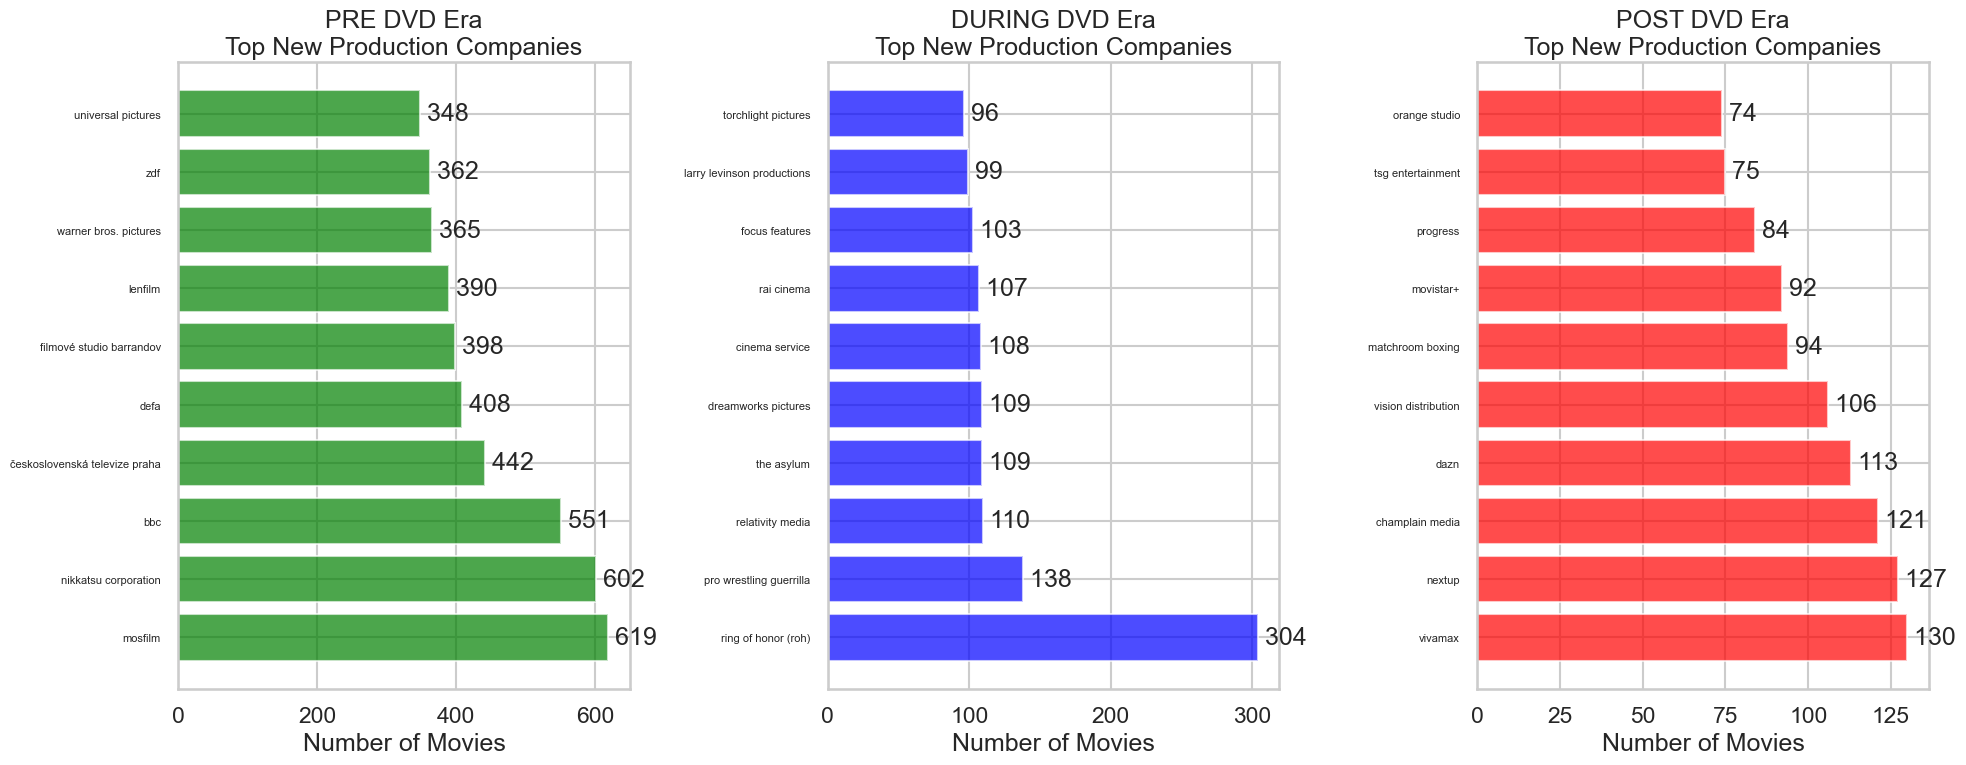


PRE DVD Era:
Total new companies: 19226

Top 5 new companies by number of movies:
mosfilm: 619 movies
nikkatsu corporation: 602 movies
bbc: 551 movies
československá televize praha: 442 movies
defa: 408 movies

DURING DVD Era:
Total new companies: 27770

Top 5 new companies by number of movies:
ring of honor (roh): 304 movies
pro wrestling guerrilla: 138 movies
relativity media: 110 movies
the asylum: 109 movies
dreamworks pictures: 109 movies

POST DVD Era:
Total new companies: 40174

Top 5 new companies by number of movies:
vivamax: 130 movies
nextup: 127 movies
champlain media: 121 movies
dazn: 113 movies
vision distribution: 106 movies


In [54]:
# Function to identify new companies and their collaboration counts
def find_new_companies(df, era, previous_eras=None):
    # Get companies from current era
    current_companies = set()
    for companies in df[df['dvd_era'] == era]['production_companies']:
        if isinstance(companies, list):  # If already a list
            current_companies.update(companies)
        else:  # If string, convert to list
            current_companies.update([companies])
    
    # Get companies from previous eras
    old_companies = set()
    if previous_eras:
        for prev_era in previous_eras:
            for companies in df[df['dvd_era'] == prev_era]['production_companies']:
                if isinstance(companies, list):
                    old_companies.update(companies)
                else:
                    old_companies.update([companies])
    
    # Find new companies
    new_companies = current_companies - old_companies
    
    # Calculate collaboration counts for new companies
    df_era = df[df['dvd_era'] == era]
    company_collabs = {}
    
    for company in new_companies:
        count = sum(1 for companies in df_era['production_companies'] 
                   if company in (companies if isinstance(companies, list) else [companies]))
        company_collabs[company] = count
    
    return company_collabs

# Get new companies for each era
pre_companies = find_new_companies(df_graph, 'pre')
during_companies = find_new_companies(df_graph, 'during', ['pre'])
post_companies = find_new_companies(df_graph, 'post', ['pre', 'during'])

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
eras = ['pre', 'during', 'post']
companies_data = [pre_companies, during_companies, post_companies]
colors = ['green', 'blue', 'red']

for ax, era, companies, color in zip(axes, eras, companies_data, colors):
    # Sort companies by number of collaborations
    top_companies = dict(sorted(companies.items(), key=lambda x: x[1], reverse=True)[:10])
    
    # Create bar plot
    bars = ax.barh(range(len(top_companies)), 
                   list(top_companies.values()),
                   color=color,
                   alpha=0.7)
    
    # Customize plot
    ax.set_yticks(range(len(top_companies)))
    ax.set_yticklabels(list(top_companies.keys()), fontsize=8)
    ax.set_title(f'{era.upper()} DVD Era\nTop New Production Companies')
    ax.set_xlabel('Number of Movies')
    
    # Add value labels
    for i, v in enumerate(top_companies.values()):
        ax.text(v, i, f' {v}', va='center')

plt.tight_layout()
plt.show()

# Print detailed statistics
for era, companies in zip(eras, companies_data):
    print(f"\n{era.upper()} DVD Era:")
    print(f"Total new companies: {len(companies)}")
    
    # Get top 5 companies
    top_5 = dict(sorted(companies.items(), key=lambda x: x[1], reverse=True)[:5])
    print("\nTop 5 new companies by number of movies:")
    for company, count in top_5.items():
        print(f"{company}: {count} movies")

In [29]:
# from ipywidgets import interact, widgets, interactive, IntSlider, Layout
# from IPython.display import display, HTML, clear_output

# # Create a slider for years and dropdown for production type
# @interact(
#     year=IntSlider(
#         min=1976,
#         max=2023,
#         step=1,
#         value=2000,
#         description='Year:',
#         continuous_update=False,  # Only update when slider is released
#         layout=Layout(width='50%')
#     ),
#     prod_type=widgets.Dropdown(
#         options=['Super', 'Big', 'Small', 'Independent'],
#         value='Super',
#         description='Production Type:'
#     )
# )
# def plot_network_by_year(year, prod_type):
#     # Clear any previous output
#     clear_output(wait=True)
    
#     # Filter data for selected year and production type
#     df_filtered = df_graph[
#         (df_graph['release_year'].astype(int) == year) & 
#         (df_graph['prod_type'] == prod_type)
#     ]
    
#     # Create edges list
#     edges = create_edges_list(df_filtered)
    
#     # Create network
#     G = nx.Graph()
#     G.add_edges_from(edges)
    
#     # Print statistics
#     print(f"\nNetwork Statistics for {year}, {prod_type} Productions:")
#     print(f"Number of nodes (production companies): {G.number_of_nodes()}")
#     print(f"Number of edges (collaborations): {G.number_of_edges()}")
#     if G.number_of_nodes() > 0:
#         print(f"Average degree (collaborations per company): {2*G.number_of_edges()/G.number_of_nodes():.2f}")
    
#     # Create interactive network visualization
#     net = Network(
#         height='600px',
#         width='100%',
#         bgcolor='#ffffff',
#         font_color='black',
#         cdn_resources='remote'
#     )
    
#     # Convert NetworkX graph to Pyvis
#     net.from_nx(G)
    
#     # Add physics options for better visualization
#     net.set_options("""
#     const options = {
#         "physics": {
#             "forceAtlas2Based": {
#                 "gravitationalConstant": -50,
#                 "centralGravity": 0.01,
#                 "springLength": 100,
#                 "springConstant": 0.08
#             },
#             "maxVelocity": 50,
#             "minVelocity": 0.1,
#             "solver": "forceAtlas2Based"
#         },
#         "nodes": {
#             "size": 20,
#             "font": {
#                 "size": 12
#             },
#             "borderWidth": 2
#         },
#         "edges": {
#             "width": 1,
#             "smooth": {
#                 "type": "continuous"
#             }
#         }
#     }
#     """)
    
#     # Save and display the graph
#     filename = f"graph_{year}_{prod_type.lower()}.html"
#     net.show(filename)
    
#     # Display the graph in the notebook
#     with open(filename, 'r', encoding='utf-8') as f:
#         html_content = f.read()
#     display(HTML(html_content))

In [30]:
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook qtconsole run server
troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [31]:
from ipywidgets import interact, widgets, IntSlider, Layout
import matplotlib.pyplot as plt
import networkx as nx

@interact(
    year=IntSlider(
        min=1976,
        max=2023,
        step=1,
        value=2000,
        description='Year:',
        continuous_update=False,
        layout=Layout(width='50%')
    ),
    prod_type=widgets.Dropdown(
        options=['Super', 'Big', 'Small', 'Independent'],
        value='Super',
        description='Production Type:'
    )
)
def plot_network_by_year(year, prod_type):
    # Clear previous plot
    plt.clf()
    
    # Filter data
    df_filtered = df_graph[
        (df_graph['release_year'].astype(int) == year) & 
        (df_graph['prod_type'] == prod_type)
    ]
    
    # Create edges list
    edges = create_edges_list(df_filtered)
    
    # Create network
    G = nx.Graph()
    G.add_edges_from(edges)
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Calculate network layout
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Draw the network
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color='lightblue',
        node_size=1000,
        font_size=8,
        font_weight='bold',
        edge_color='gray',
        width=0.5,
        alpha=0.7
    )
    
    # Add title with statistics
    plt.title(f"Production Company Network - {year} ({prod_type} Productions)\n" +
              f"Companies: {G.number_of_nodes()}, " +
              f"Collaborations: {G.number_of_edges()}, " +
              f"Avg. Collaborations per Company: {2*G.number_of_edges()/G.number_of_nodes():.2f}" if G.number_of_nodes() > 0 else "No data",
              pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print additional statistics
    if G.number_of_nodes() > 0:
        print("\nTop 5 Companies by Number of Collaborations:")
        degrees = dict(G.degree())
        top_companies = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]
        for company, degree in top_companies:
            print(f"{company}: {degree} collaborations")

interactive(children=(IntSlider(value=2000, continuous_update=False, description='Year:', layout=Layout(width=…

In [32]:
from ipywidgets import interact, widgets, IntSlider, Layout
import matplotlib.pyplot as plt
import networkx as nx

@interact(
    year=IntSlider(
        min=1976,
        max=2023,
        step=1,
        value=2000,
        description='Year:',
        continuous_update=False,
        layout=Layout(width='50%')
    ),
    prod_type=widgets.Dropdown(
        options=['Super', 'Big', 'Small', 'Independent'],
        value='Super',
        description='Production Type:'
    )
)
def plot_network_by_year(year, prod_type):
    # Clear previous plot
    plt.clf()
    
    # Filter data
    df_filtered = df_graph[
        (df_graph['release_year'].astype(int) == year) & 
        (df_graph['prod_type'] == prod_type)
    ]
    
    # Create edges list
    edges = create_edges_list(df_filtered)
    
    # Create network
    G = nx.Graph()
    G.add_edges_from(edges)
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Calculate network layout with adjusted parameters for better spacing
    pos = nx.spring_layout(G, k=2, iterations=50)
    
    # Calculate node sizes based on degree (number of connections)
    degrees = dict(G.degree())
    node_sizes = [((v + 1) * 500) for v in degrees.values()]
    
    # Draw the network with enhanced visuals
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color='lightblue',
        node_size=node_sizes,  # Nodes sized by importance
        font_size=8,
        font_weight='bold',
        edge_color='lightgray',
        width=0.3,
        alpha=0.7
    )
    
    # Add title with enhanced statistics
    plt.title(
        f"Production Company Network - {year} ({prod_type} Productions)\n" +
        f"Companies: {G.number_of_nodes():,}, " +
        f"Collaborations: {G.number_of_edges():,}\n" +
        f"Avg. Collaborations per Company: {2*G.number_of_edges()/G.number_of_nodes():.1f}" if G.number_of_nodes() > 0 else "No data",
        pad=20,
        fontsize=14,
        fontweight='bold'
    )
    
    plt.tight_layout()
    plt.show()
    
    # Print enhanced statistics
    if G.number_of_nodes() > 0:
        print("\nNetwork Statistics:")
        print(f"Density: {nx.density(G):.3f}")
        if nx.is_connected(G):
            print(f"Average Path Length: {nx.average_shortest_path_length(G):.2f}")
        
        print("\nTop 5 Companies by Number of Collaborations:")
        degrees = dict(G.degree())
        top_companies = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]
        for i, (company, degree) in enumerate(top_companies, 1):
            print(f"{i}. {company}: {degree} collaborations")

interactive(children=(IntSlider(value=2000, continuous_update=False, description='Year:', layout=Layout(width=…

Network density measures how many connections are present compared to how many connections are possible in the network. A higher density means more collaboration in the industry

In [33]:
# Get number of production companies for each movie 
num_production_companies = df['production_companies'].str.len()

# Get most common number of production companies with their counts 
company_counts = num_production_companies.value_counts().sort_index()
company_counts.head()

production_companies
0    187695
1    106039
2     37111
3     17122
4      7070
Name: count, dtype: int64

Notice, there are many movies with no production companies, we will make sure to exclude these for this part of the analysis. 


In [34]:
print(f"Movies with no production company: {company_counts.get(0, 0):,} ({company_counts.get(0, 0)/company_counts.sum()*100:.1f}%)")
print(f"Movies with single production company: {company_counts.get(1, 0):,} ({company_counts.get(1, 0)/company_counts.sum()*100:.1f}%)")
print(f"Movies with multiple production companies: {company_counts[company_counts.index > 1].sum():,} ({company_counts[company_counts.index > 1].sum()/company_counts.sum()*100:.1f}%)")

Movies with no production company: 187,695 (51.6%)
Movies with single production company: 106,039 (29.2%)
Movies with multiple production companies: 69,708 (19.2%)



Considering movies that have >=1 production company, we plot the frequency distribution. 

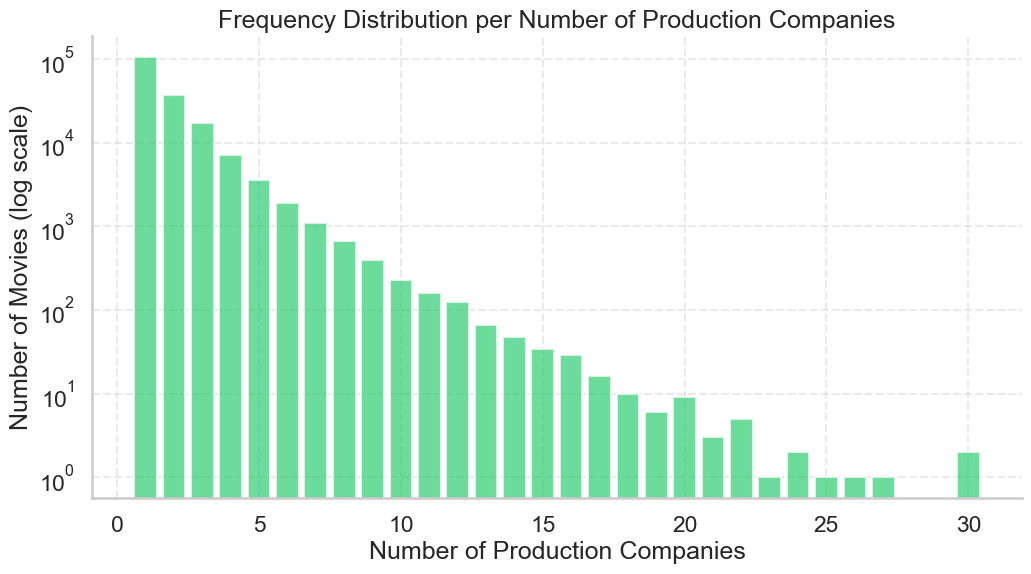

In [35]:
company_counts = company_counts[company_counts.index > 0]
plt.figure(figsize=(12, 6))
plt.bar(company_counts.index, company_counts.values, color='#2ecc71', alpha=0.7, edgecolor='white')

plt.yscale('log')
style_plot('Frequency Distribution per Number of Production Companies', 'Number of Production Companies', 'Number of Movies (log scale)', False)

 Interestingly, there are a high number of movies with more than one production company. Production companies have the resources (creative or financial) to make the movies possible. It would be interesting to see how the number of production companies per movie has evolved over time. 

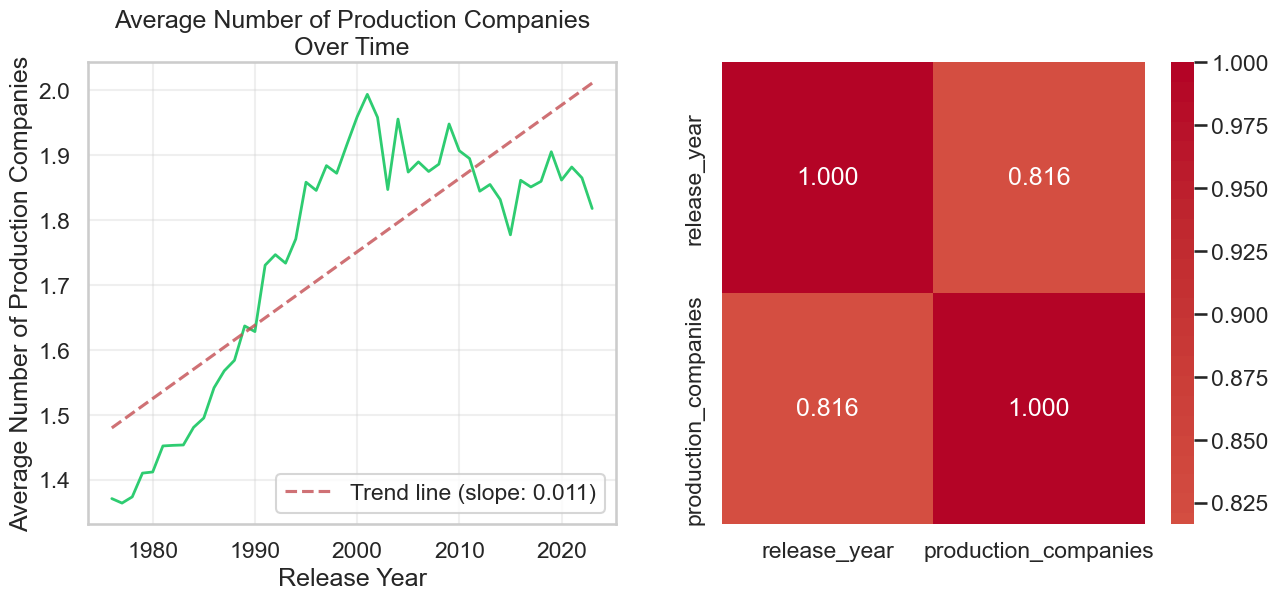

In [36]:
# Get mean number of production companies per year
yearly_avg_companies = (df[df['production_companies'].str.len() > 0].groupby('release_year')
                       .agg({'production_companies': lambda x: x.str.len().mean()})
                       .reset_index())

# Create 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot mean number of production companies per year
ax1.plot(yearly_avg_companies['release_year'], 
             yearly_avg_companies['production_companies'],
             linewidth=2,
             color='#2ecc71')

# Add linear fit to the plot 
z = np.polyfit(yearly_avg_companies['release_year'], 
               yearly_avg_companies['production_companies'], 1)
p = np.poly1d(z)
ax1.plot(yearly_avg_companies['release_year'], 
         p(yearly_avg_companies['release_year']), 
         "r--", 
         alpha=0.8,
             label=f'Trend line (slope: {z[0]:.3f})')

ax1.set_title('Average Number of Production Companies\nOver Time')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Average Number of Production Companies')
ax1.grid(True, alpha=0.3)
ax1.legend()
    
correlation = yearly_avg_companies['release_year'].corr(yearly_avg_companies['production_companies'])
covariance = yearly_avg_companies['release_year'].cov(yearly_avg_companies['production_companies'])

# Plot correlation between number of production companies and release year
sns.heatmap(yearly_avg_companies.corr(), 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.3f',
                ax=ax2)
plt.show()


From this initial analysis, there is a strong correlation between the number of production companies per movie and the release year. 

In [37]:
print(df['production_companies'].explode().value_counts().describe())

count    87170.000000
mean         3.613812
std         18.185170
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1439.000000
Name: count, dtype: float64


We then plot the number of movies produced per production company, considering production companies in decreasing order in terms of how many movies they produce. We use a log-log scale and notice a power law trend.

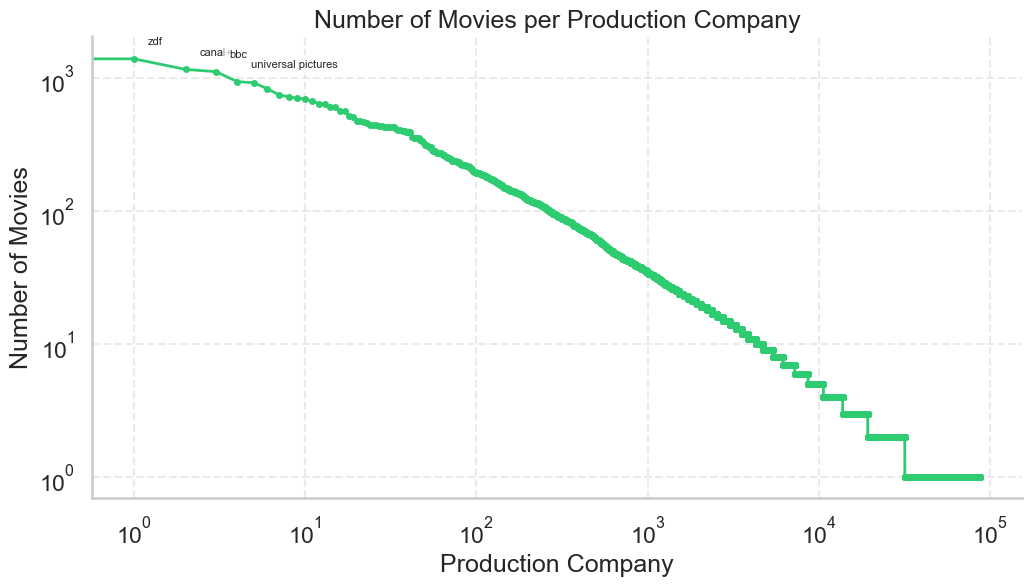

In [38]:
plot_movie_freq_per_production_company(df)

This plot here shows us the number of movies each production company has produced. Notice that there are huge differences in the number of movies produced by each production company and clear 'dominance' of a few production companies. Let's look at those dominant production compnaies by looking atthe top 100 production companies. 

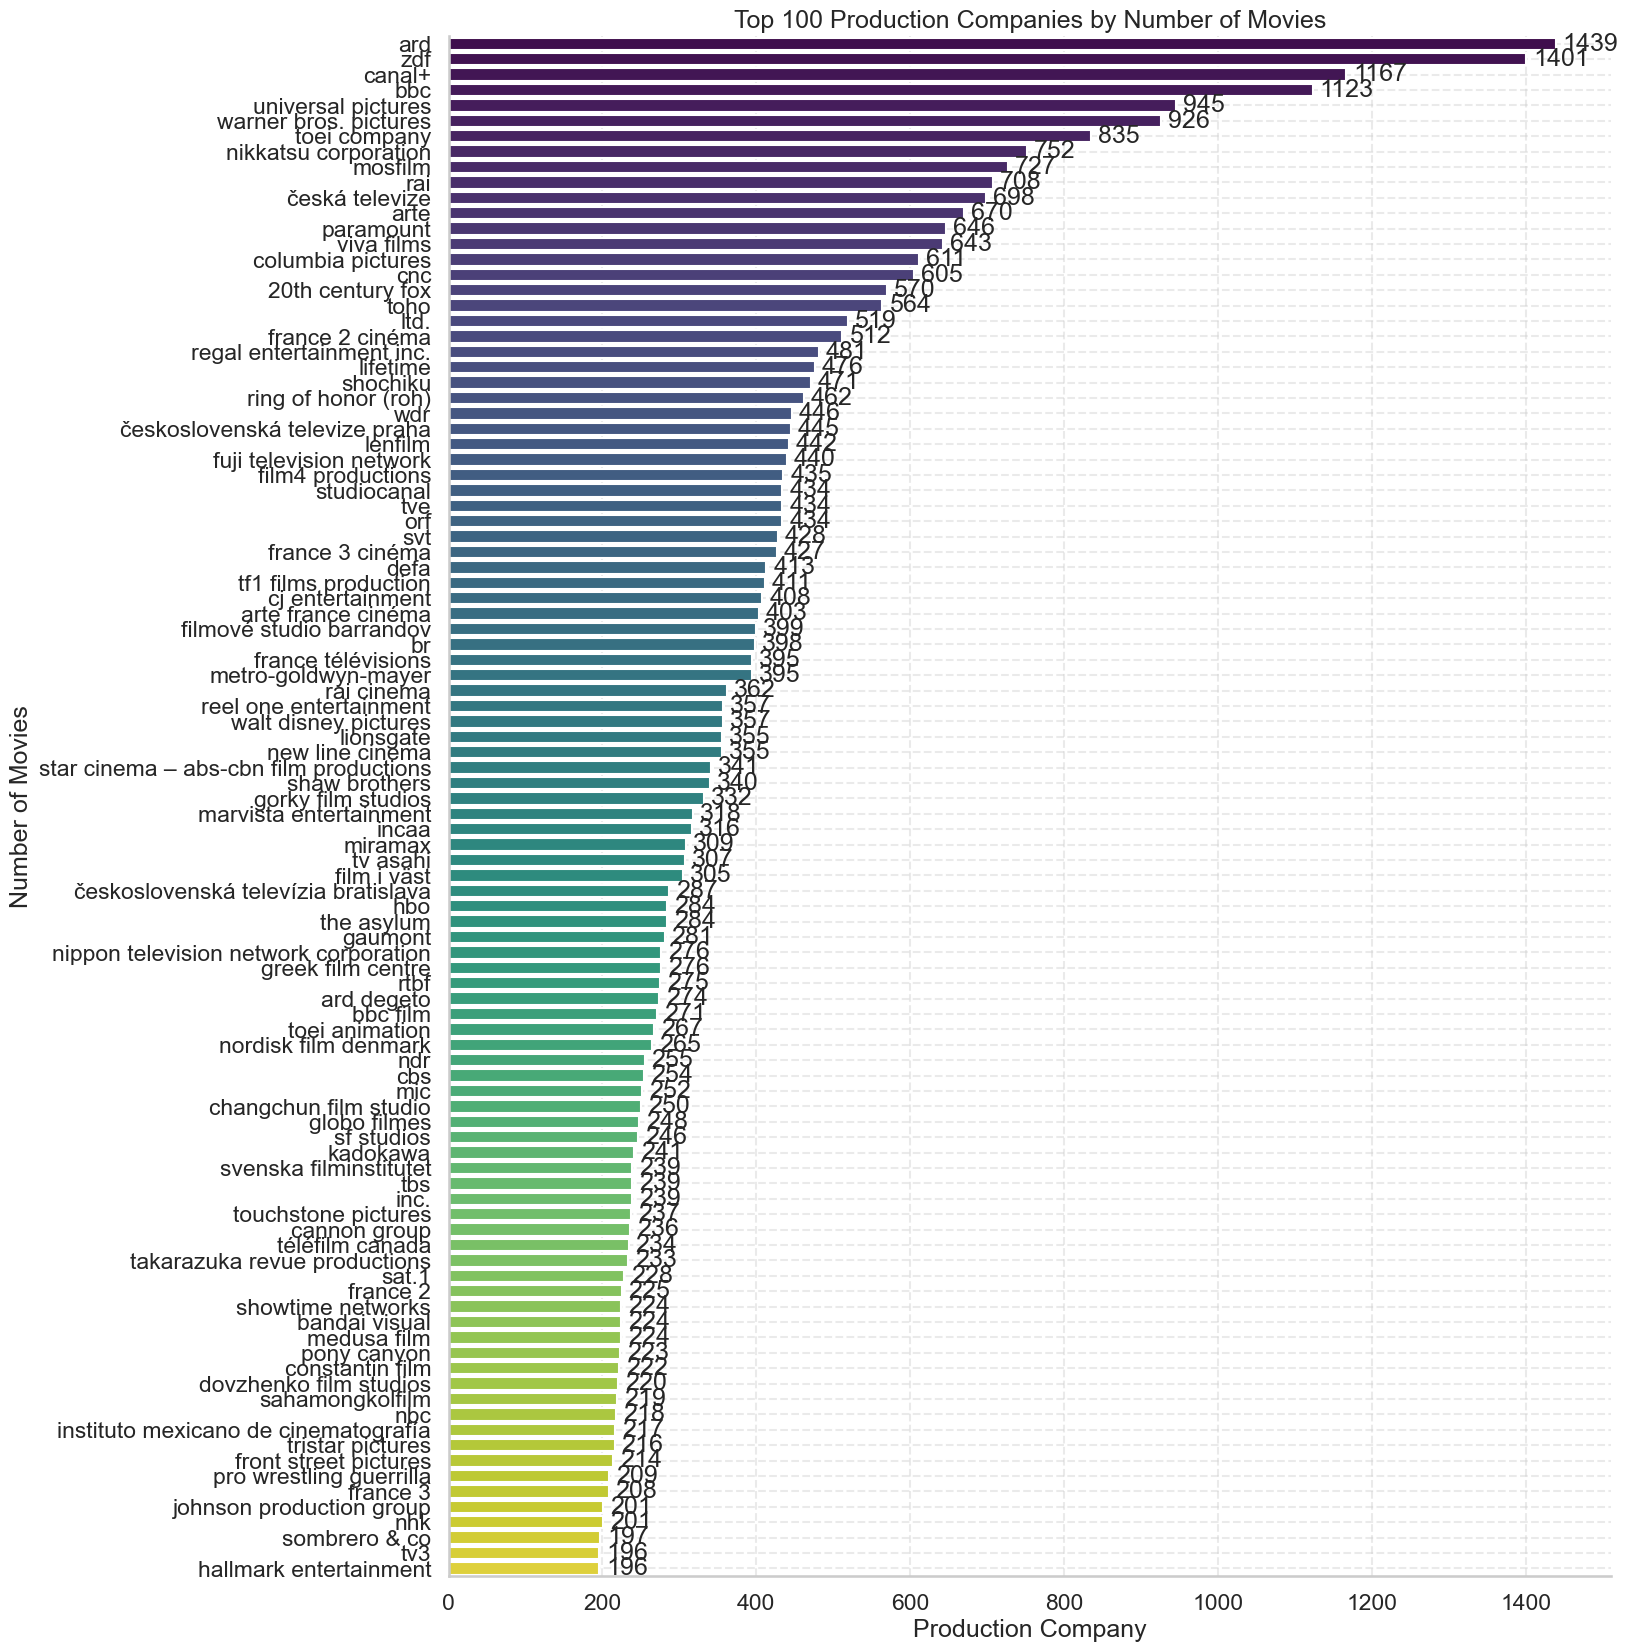

In [39]:
# Get number of movies produced by top 100 production companies
top_100_companies = df['production_companies'].explode().value_counts().head(100)

# plot the values 
plt.figure(figsize=(15, 20))

ax = sns.barplot(
    y=top_100_companies.index,
    x=top_100_companies.values,
    palette='viridis',
    hue=top_100_companies.index,
    legend=False
)
for i in ax.containers:
    ax.bar_label(i, padding=5)
ax.grid(axis='x', linestyle='--', alpha=0.7)
style_plot('Top 100 Production Companies by Number of Movies', 'Production Company', 'Number of Movies', False)

There are some production companies that have a very high number of movies for P3 it would be interesting to find out why they are so successful 

# Runtime overview

We get an overview of the movie runtimes, excluding movies that do not have a runtime associated

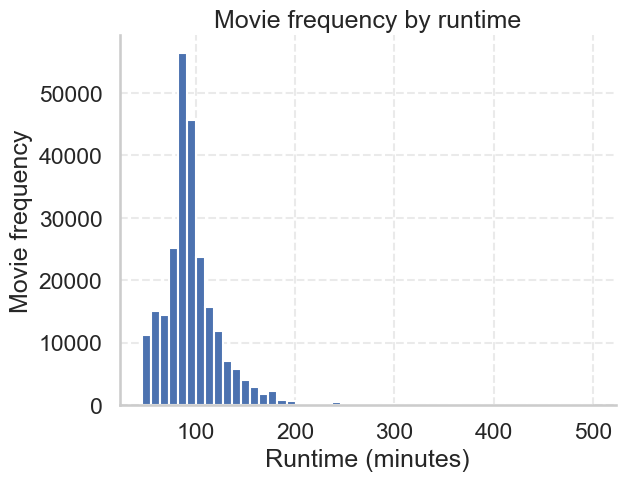

In [40]:
# General runtime distribution
plt.hist(df[(df['runtime'] > 0)]['runtime'], bins=50)
style_plot(title='Movie frequency by runtime', xlabel='Runtime (minutes)', ylabel='Movie frequency')

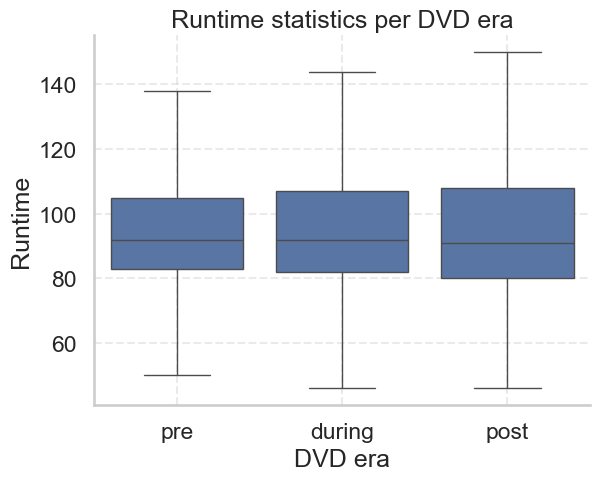

In [41]:
# Runtime statistics in boxplot 
sns.boxplot(x='dvd_era', y='runtime', data=df[df['runtime'] > 0], showfliers=False, order=['pre', 'during', 'post'])
style_plot(title='Runtime statistics per DVD era', xlabel='DVD era', ylabel='Runtime')

In [42]:
df[df.runtime >0].groupby('dvd_era')['runtime'].describe().reindex(['pre', 'during', 'post']).transpose()

dvd_era           pre        during           post
count    60259.000000  83718.000000  103082.000000
mean        96.264774     97.605007      97.573864
std         29.555468     32.726680      34.203319
min         46.000000     46.000000      46.000000
25%         83.000000     82.000000      80.000000
50%         92.000000     92.000000      91.000000
75%        105.000000    107.000000     108.000000
max        500.000000    500.000000     500.000000

There does not seem to be considerable differences in runtime statistics across the DVD eras. 

# Genre overview
For each DVD era, we obtain the top-10 movie genres based on the proportion of movies.


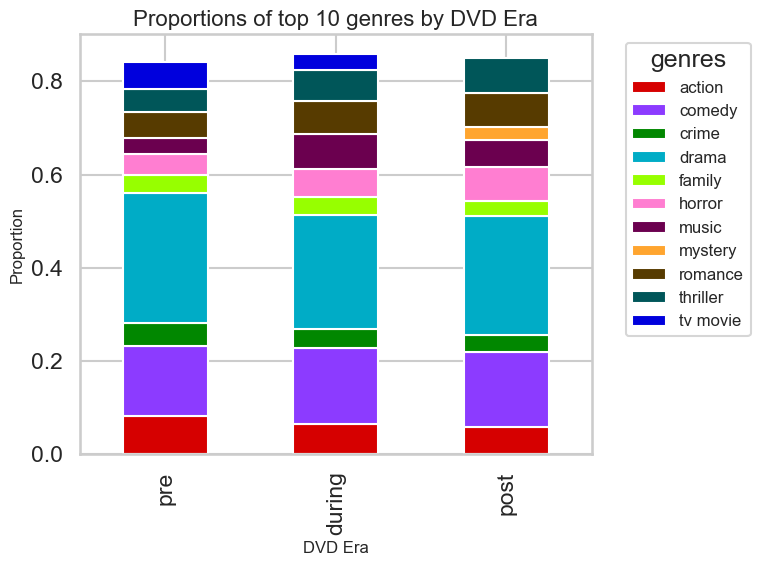

In [43]:
top_10_genre =top_proportions_per_era(df, 'genres', 10, True)
plot_top_proportions_per_era(top_10_genre, 'genres', 10)

We can see that drama is the most common genre across all eras, closely followed by comedy. We also see that the proportion of movies per genre stays relatively stable, except for TV Movies that disappear from the top 10 and Mystery movies that become more common in the post-DVD era. We need to examine these trends more closely and use statistical tests to determine if there are significant differences between DVD eras. 

# Theme extraction

For the major genres, we use LDA to extract the main topics in movies of the genre, with the goal of checking whether the main topics change overtime. Here is an example of topic extraction for the Drama movie genre, which appears to be the most common genre in the plot above. 

In [44]:
# Pre-process movie plots, lowercase, removing stopwords & special characters
df['clean_overview'] = df.overview.apply(clean_text)

# Extract plots for Drama genre and pre-DVD era
text_data = get_movie_plots(df, 'drama', 'pre')
# Extract 3 main topics 
model = LDAModel(text_data, 3)
model.train()
model.plot_topics()

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/Users/charlottemeyer/nltk_data'
    - '/Users/charlottemeyer/Documents/EPFL - Applied Data Analysis/ada-2024-project-databand/.conda/nltk_data'
    - '/Users/charlottemeyer/Documents/EPFL - Applied Data Analysis/ada-2024-project-databand/.conda/share/nltk_data'
    - '/Users/charlottemeyer/Documents/EPFL - Applied Data Analysis/ada-2024-project-databand/.conda/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


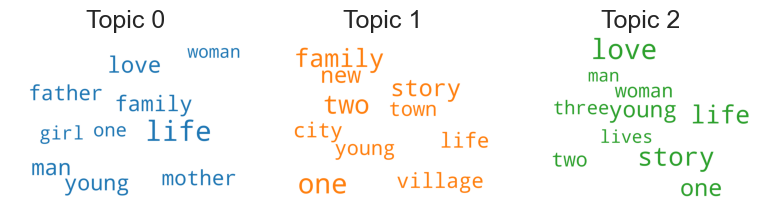

In [ ]:
text_data = get_movie_plots(df, 'drama', 'during')
model = LDAModel(text_data, 3)
model.train()
model.plot_topics()

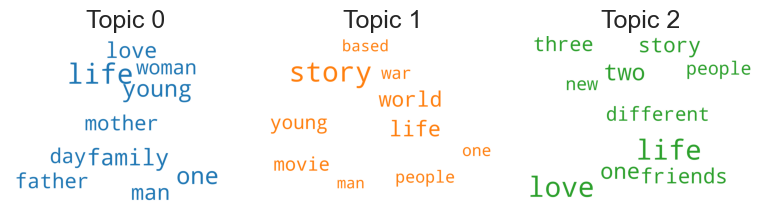

In [ ]:
text_data = get_movie_plots(df, 'drama', 'post')
model = LDAModel(text_data, 3)
model.train()
model.plot_topics()

# Special types of movies
## Remakes 


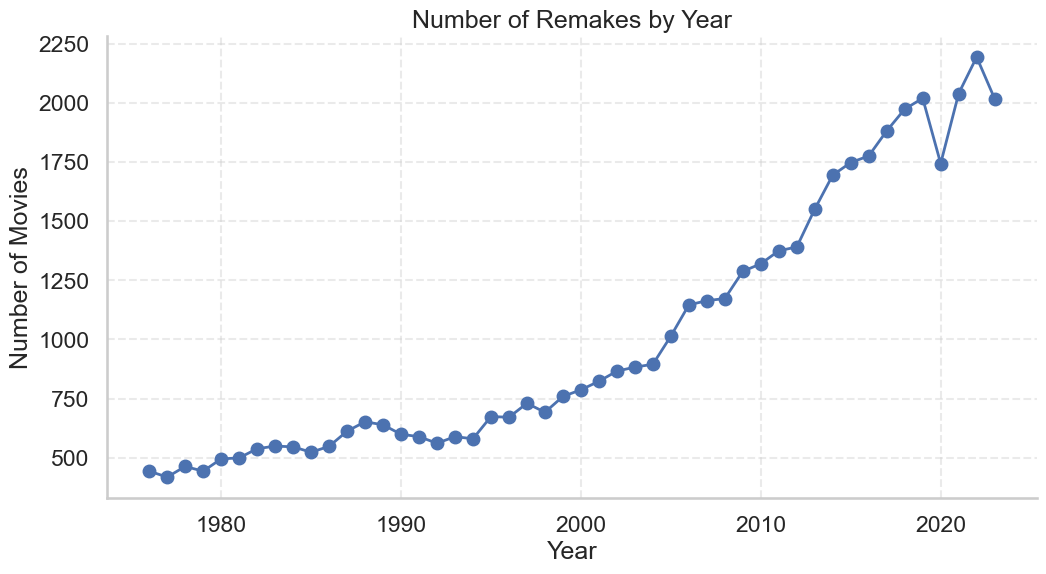

In [ ]:
remakes = (df.groupby('title')
           .agg({'release_year': ['count']}) # count for each year the number of times the same title appears
           .reset_index())

remakes = remakes[remakes[('release_year', 'count')] > 1] # Ensure we only keep titles that appear multiple times

yearly_remakes = (df[df['title'].isin(remakes['title'])]
                 .groupby('release_year')
                 .size())

plt.figure(figsize=(12, 6))
plt.plot(yearly_remakes.index, yearly_remakes.values, 
         marker='o', 
         linewidth=2)
style_plot('Number of Remakes by Year', 'Year', 'Number of Movies', False)

In [ ]:
remakes.head()

title release_year
                                             count
66                                  #            2
266  'twas the night before christmas            2
350                                +1            2
369                                 .            3
506                                 1            4

In [ ]:
print(remakes.info())

<class 'pandas.core.frame.DataFrame'>
Index: 16837 entries, 66 to 329564
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   (title, )              16837 non-null  object
 1   (release_year, count)  16837 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 394.6+ KB
None
